In [ ]:
from ase.io import read, write
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core import Composition, Structure
from typing import List, Tuple

import re, joblib, json
import numpy as np
import pandas as pd
from keras.utils import to_categorical

import pandas as pd
from ase.io import read, write
from ase import Atoms
from ase.db import connect
import numpy as np
import sys, os
from spglib import get_spacegroup, find_primitive, standardize_cell
import pymatgen 
from pymatgen.io.ase import AseAtomsAdaptor
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # for cross-validation
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from pymatgen.core import Composition, Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


import os

bridge = AseAtomsAdaptor()

import warnings
warnings.filterwarnings("ignore")


### Pretty ploting routine

In [ ]:
def reset_plt(ticksize,fontsize):
    #plt.style.use('whitegrid')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    #plt.rcParams['axes.formatter.limits'] = (-1,3)
    #plt.rcParams['axes.linewidth'] = 2.25
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)


### PyTorch


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import math
from tqdm import tqdm
val_ratio = 0.2
test_ratio = 0.1
batch_size = 32
lr = 0.001
epochs = 10

X = np.load('X_2D.npy')
Y = np.load('Y_2D.npy')
print('X:',X.shape)
print('Y:',Y.shape)

# Setup scaler for Y
scaler_Y = StandardScaler()
Y_scaled = Y.copy()
Y_scaled[:,:6] = scaler_Y.fit_transform(Y[:,:6])
# Set X and Y to torch tensors
Y = Y_scaled


test_size = 0.2
val_size = 0.1

x_train_val,x_test,y_train_val,y_test=train_test_split( X \
                                               ,Y,test_size=test_size)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size=val_size)
print('Train:',x_train.shape,y_train.shape)
print('Val:',x_val.shape,y_val.shape)
print('Test:',x_test.shape,y_test.shape)

# 2. Define a custom Dataset class
class CrystalDataset(Dataset):
    def __init__(self, X, Y):
        """
        Initialize the dataset.
        
        Args:
        X (numpy array): Atomic features with shape (N, feature_dim, wyckoff_dim).
        Y (numpy array): Crystal features with shape (N, crystal_dim).
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieve an item at the specified index.
        
        Args:
        idx (int): Index of the item.
        
        Returns:
        Tuple[Tensor, Tensor]: Atomic and crystal features.
        """
        return self.X[idx], self.Y[idx]

# 3. Create Dataset and DataLoader for each split
train_dataset = CrystalDataset(x_train, y_train)
val_dataset = CrystalDataset(x_val, y_val)
#test_dataset = CrystalDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X: (9017, 180, 24)
Y: (9017, 236)
Train: (6491, 180, 24) (6491, 236)
Val: (722, 180, 24) (722, 236)
Test: (1804, 180, 24) (1804, 236)


In [ ]:
# Example usage: Iterate through the train_loader
for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"x_batch shape: {x_batch.shape}")  # Shape: (batch_size, 131, 24)
    print(f"y_batch shape: {y_batch.shape}")  # Shape: (batch_size, 236)
    break

Batch 1
x_batch shape: torch.Size([32, 180, 24])
y_batch shape: torch.Size([32, 236])


In [ ]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, feature_dim, wyckoff_dim, crystal_dim,space_group_dim=230,lattice_dim=6,
                  stride= [2,2,1],kernel=[3,3,4],latent_dim=256, max_filter=64,verbose=False):
        super(VAE, self).__init__()
        self.feature_dim = feature_dim
        self.wyckoff_dim = wyckoff_dim
        self.crystal_dim = crystal_dim
        self.space_group_dim = space_group_dim
        self.stride = stride
        self.kernel_size = kernel
        self.latent_dim = latent_dim
        self.max_filter = max_filter
        self.verbose = verbose
        self.map_size = 3 

        # Encoder: Atomic features
        self.encoder_conv1 = nn.Conv1d(feature_dim, max_filter // 2 , kernel_size=self.kernel_size[0], stride=self.stride[0], padding=0)
        self.encoder_conv2 = nn.Conv1d(max_filter // 2, max_filter // 4, kernel_size=self.kernel_size[1], stride=self.stride[1], padding=0)
        self.encoder_conv3 = nn.Conv1d(max_filter // 4, max_filter, kernel_size=self.kernel_size[2], stride=self.stride[2], padding=0)

        self.encoder_bn1 = nn.BatchNorm1d(max_filter // 2)
        self.encoder_bn2 = nn.BatchNorm1d(max_filter // 4)
        self.encoder_bn3 = nn.BatchNorm1d(max_filter)
        
        self.encoder_fc = nn.Linear(max_filter * (self.map_size) , 1024) #### TODO: NEED TO CHANGE THIS TO BE DYNAMIC

        # Encoder: Crystal features
        self.crystal_fc1 = nn.Linear(crystal_dim, 256)
        self.crystal_fc2 = nn.Linear(256, 128)

        # Latent space
        self.z_mean = nn.Linear(1024 + 128, latent_dim)
        self.z_log_var = nn.Linear(1024 + 128, latent_dim)

        # Decoder: Crystal features
        self.decoder_crystal_fc = nn.Linear(latent_dim, crystal_dim)
        self.decoder_sg = nn.Linear(crystal_dim, space_group_dim)  # 230 space groups
        self.decoder_lattice = nn.Linear(crystal_dim, lattice_dim) # 6 lattice constants and angles

        # Decoder: Atomistic features
        self.decoder_fc = nn.Linear(latent_dim, feature_dim * self.map_size)
        self.decoder_conv1 = nn.ConvTranspose1d(feature_dim, max_filter, kernel_size=self.kernel_size[2], stride=self.stride[2])
        self.decoder_conv2 = nn.ConvTranspose1d(max_filter , max_filter // 4 , kernel_size=self.kernel_size[1], stride=self.stride[1],)
        self.decoder_conv3 = nn.ConvTranspose1d(max_filter // 4, feature_dim, kernel_size=self.kernel_size[0], stride=self.stride[0],)
        self.decoder_bn1 = nn.BatchNorm1d(max_filter)
        self.decoder_bn2 = nn.BatchNorm1d(max_filter // 4)

        self.decoder_out = nn.Linear(latent_dim, feature_dim * wyckoff_dim)

    def encode(self, x, x2):
        # Atomic feature encoding
        if self.verbose:
            print('X:',x.shape)
            print('X2:',x2.shape)
        #x = x.permute(0, 2, 1)
        #print(x.shape,x2.shape)
        en0 = F.leaky_relu(self.encoder_bn1(self.encoder_conv1(x)), negative_slope=0.2)        
        en1 = F.leaky_relu(self.encoder_bn2(self.encoder_conv2(en0)), negative_slope=0.2)
        en2 = F.leaky_relu(self.encoder_bn3(self.encoder_conv3(en1)), negative_slope=0.2)
        en3 = en2.view(en2.size(0), -1)  # Flatten
        en4 = F.relu(self.encoder_fc(en3))

        if self.verbose:
            print('En0:',en0.shape)
            print('En1:',en1.shape)
            print('En2:',en2.shape)
            print('En3:',en3.shape)
            print('En4:',en4.shape)
            print('---------------------------------')

        # Crystal feature encoding

        cry0 = F.relu(self.crystal_fc1(x2))
        cry1 = F.relu(self.crystal_fc2(cry0))

        if self.verbose:
            print('Cry0:',cry0.shape)
            print('Cry1:',cry1.shape)
            print('---------------------------------')

        # Combine atomic and crystal features
        latent = torch.cat((en4, cry1), dim=1)
        z_mean = self.z_mean(latent)
        z_log_var = self.z_log_var(latent)

        if self.verbose:
            print('Latent indput',latent.shape)
            print('Z mean',z_mean.shape,'Z_std',z_log_var.shape)
            print('---------------------------------')

        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def decode(self, z):
        # Decode crystal features
        if self.verbose:
            print('Z:',z.shape)

        crystal_features = F.relu(self.decoder_crystal_fc(z))
        decoded_sg = F.softmax(self.decoder_sg(crystal_features), dim=1)
        decoded_lattice = self.decoder_lattice(crystal_features)


        if self.verbose:
            print('Crystal Features:',crystal_features.shape)
            print('Decoded SG:',decoded_sg.shape)
            print('Decoded Lattice:',decoded_lattice.shape)
            print('---------------------------------')

        # Decode atomistic features
        dec0 = F.relu(self.decoder_fc(z))
        dec1 = dec0.view(dec0.size(0), self.feature_dim, self.map_size)
        dec2 = F.relu(self.decoder_bn1(self.decoder_conv1(dec1)))
        dec3 = F.relu(self.decoder_bn2(self.decoder_conv2(dec2)))
        reconstructed_outputs = self.decoder_conv3(dec3)

        if self.verbose:
            print('Dec0:',dec0.shape)
            print('Dec1:',dec1.shape)
            print('Dec2:',dec2.shape)
            print('Dec3:',dec3.shape)
            print('Output',reconstructed_outputs.shape)
            print('---------------------------------')

        return reconstructed_outputs, decoded_sg, decoded_lattice

    def forward(self, x, x2):
        # Encode
        z_mean, z_log_var = self.encode(x, x2)
        # Latent space sampling
        z = self.sampling(z_mean, z_log_var)
        # Decode
        reconstructed_outputs, decoded_sg, decoded_lattice = self.decode(z)
        outputs = {'reconstructed_outputs':reconstructed_outputs,
                   'decoded_sg':decoded_sg,
                   'decoded_lattice':decoded_lattice,
                   'z_mean':z_mean,
                   'z_log_var':z_log_var}
        return outputs

# Initialize the VAE
feature_dim = X.shape[1]
wyckoff_dim = X.shape[2]
crystal_dim = Y.shape[1]
kernel = [2,2,4]
stride = [2,2,1]

vae = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=True,kernel=kernel,stride=stride)
# Test the forward pass
x_batch, y_batch = next(iter(train_loader))
out = vae(x_batch, y_batch)

# NOTE: Kernel add an extra dimension for the wyckoff sites 

X: torch.Size([32, 180, 24])
X2: torch.Size([32, 236])
En0: torch.Size([32, 32, 12])
En1: torch.Size([32, 16, 6])
En2: torch.Size([32, 64, 3])
En3: torch.Size([32, 192])
En4: torch.Size([32, 1024])
---------------------------------
Cry0: torch.Size([32, 256])
Cry1: torch.Size([32, 128])
---------------------------------
Latent indput torch.Size([32, 1152])
Z mean torch.Size([32, 256]) Z_std torch.Size([32, 256])
---------------------------------
Z: torch.Size([32, 256])
Crystal Features: torch.Size([32, 236])
Decoded SG: torch.Size([32, 230])
Decoded Lattice: torch.Size([32, 6])
---------------------------------
Dec0: torch.Size([32, 540])
Dec1: torch.Size([32, 180, 3])
Dec2: torch.Size([32, 64, 6])
Dec3: torch.Size([32, 16, 12])
Output torch.Size([32, 180, 24])
---------------------------------
X: torch.Size([2, 180, 24])
X2: torch.Size([2, 236])
En0: torch.Size([2, 32, 12])
En1: torch.Size([2, 16, 6])
En2: torch.Size([2, 64, 3])
En3: torch.Size([2, 192])
En4: torch.Size([2, 1024])
--

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:

# Defien loss function and test it
# Define the VAE loss function
def vae_loss_function(model_output, x, y, coeffs,verbose=False):
    """
    Compute the VAE loss.

    Args:
    reconstructed_x (Tensor): Reconstructed output from the decoder.
    x (Tensor): Original input.
    z_mean (Tensor): Mean of the latent variable.
    z_log_var (Tensor): Log variance of the latent variable.
    coeffs (dict): Coefficients for different loss components.

    Returns:
    Tensor: Total loss (scalar).
    """   
    # VAE loss consists of two components: 
    # 1. KL divergence loss. That is a measure of divergence between two distributions.
    # 2. Reconstruction loss for the atoms. That we will seperate into several lossed for each component we want to reconstruct
    # 3. Reconstruction loss for the crystal features
    # We want to minimize the reconstruction loss and the KL divergence loss.
    # Mean over the batch to make the training independent of the batch size.

    # Initialize the losses
    losses = {}

    # Get the model output
    z_mean = model_output['z_mean']
    z_log_var = model_output['z_log_var']
    reconstructed_x = model_output['reconstructed_outputs']
    decoded_sg = model_output['decoded_sg']
    decoded_lattice = model_output['decoded_lattice']

    if verbose:
        print('Reconstructed:',reconstructed_x.shape)
        print('Original:',x.shape)
        print('Z mean:',z_mean.shape)
        print('Z log var:',z_log_var.shape)
        print('Coeffs:',coeffs)
        print('---------------------------------')
    
    #### KL Divergence loss ####
    kl_loss_i = -0.5 * (1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var))
    kl_loss = torch.mean(torch.sum(kl_loss_i, dim=1)) # sum over the latent dimensions and mean over the batch
    losses['kl'] = kl_loss
    if verbose:
        print('KL Loss i:',kl_loss_i.shape)
        print('KL Loss:',kl_loss.shape)

    #### Reconstruction loss atomistic features ####
    # Reconstruction loss of the elemental features
    # The element embedding should always sum to 1
    # Softmax on all wyckoff sites
    element_loss_i = torch.mean(torch.square(F.softmax(reconstructed_x[:,:101,:],dim=1) - x[:,:101,:]),dim=1) # MSE between the softmax distribution and the true distribution
    element_loss = torch.mean(torch.sum(element_loss_i,dim=1)) # sum over the wyckoff_sites and mean over the batch
    losses['element'] = element_loss
    if verbose:
        print('Element Loss i:',element_loss_i.shape)
        print('Element Loss:',element_loss_i.shape)

    # Wyckoff sites reconstruction loss. Cross entropy loss
    wyckoff_site_loss_i = F.cross_entropy(reconstructed_x[:,-26:,:], x[:,-26:,:],reduction='none')
    wyckoff_site_loss = torch.mean(torch.sum(wyckoff_site_loss_i,dim=1)) # sum over the wyckoff sites and mean over the batch
    losses['wyckoff_sites'] = wyckoff_site_loss
    if verbose:
        print('Wyckoff Loss i:',wyckoff_site_loss_i.shape)
        print('Wyckoff Loss:',wyckoff_site_loss.shape)

    # Wyckoof multiplier loss. Cross entropy loss
    wyckoff_multiplier_loss_i = F.cross_entropy(reconstructed_x[:,101:-29,:], x[:,101:-29,:],reduction='none')
    wyckoff_multiplier_loss = torch.mean(torch.sum(wyckoff_multiplier_loss_i,dim=1)) # sum over the wyckoff sites and mean over the batch
    losses['wyckoff_multiplier'] = wyckoff_multiplier_loss
    if verbose:
        print('Wyckoff Multiplier Loss i:',wyckoff_multiplier_loss_i.shape)
        print('Wyckoff Multiplier Loss:',wyckoff_multiplier_loss.shape)
    
    # Fractional coordinates reconstruction loss. Mean squared error loss
    frac_coords_loss_i = torch.mean(torch.square(reconstructed_x[:,-29:-26,:] - x[:,-29:-26,:]),dim=2) # mse over the wyckoff sites 
    frac_coords_loss_j = torch.sum(frac_coords_loss_i,dim=1) # sum over the fractional coordinates
    frac_coords_loss = torch.mean(frac_coords_loss_j) # mean over the batch
    losses['frac_coords'] = frac_coords_loss
    if verbose:
        print('Frac Coords Loss i:',frac_coords_loss_i.shape)
        print('Frac Coords Loss:',frac_coords_loss.shape)

    #### Reconstruction loss crystal features ####
    # Space group loss. Cross entropy loss
    space_group_loss_i = F.cross_entropy(decoded_sg, y[:,6:],reduce=False)
    space_group_loss = torch.mean(space_group_loss_i) # mean over the batch
    losses['space_group'] = space_group_loss
    if verbose:
        print('Space Group Loss i:',space_group_loss_i.shape)
        print('Space Group Loss:',space_group_loss.shape)

    # Lattice loss. Mean squared error loss
    lattice_loss_i = F.mse_loss(decoded_lattice, y[:,:6],reduce=False)
    lattice_loss = torch.mean(torch.sum(lattice_loss_i,dim=1)) # sum over the lattice constants and mean over the batch
    losses['lattice'] = lattice_loss
    if verbose:
        print('Lattice Loss i:',lattice_loss_i.shape)
        print('Lattice Loss:',lattice_loss.shape)

    # Weighted sum of losses
    for key in losses:
        losses[key] *= coeffs[key]

    # Total loss
    total_loss = torch.sum(torch.stack(list(losses.values()))) # Take all the losses and make them to a list of torch objects then stack them to make them a tensor and sum them
    losses['total'] = total_loss
    if verbose:
        print('Total Loss:',total_loss.shape)
        print('---------------------------------')

    return losses
coeffs = {'kl': 6.0,
          'element':500.0,
          'wyckoff_sites': 1.0,
        'wyckoff_multiplier': 1.0,
          'frac_coords': 100.0,
          'space_group':10.0,
          'lattice':6.0}
# Forward pass
vae = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=False,kernel=kernel,stride=stride)
out = vae(x_batch, y_batch)

# Compute loss
loss = vae_loss_function(out, x_batch, y_batch, coeffs,verbose=True);
for key in loss:
    print(f"{key}: {loss[key]}")

Reconstructed: torch.Size([32, 180, 24])
Original: torch.Size([32, 180, 24])
Z mean: torch.Size([32, 256])
Z log var: torch.Size([32, 256])
Coeffs: {'kl': 6.0, 'element': 500.0, 'wyckoff_sites': 1.0, 'wyckoff_multiplier': 1.0, 'frac_coords': 100.0, 'space_group': 10.0, 'lattice': 6.0}
---------------------------------
KL Loss i: torch.Size([32, 256])
KL Loss: torch.Size([])
Element Loss i: torch.Size([32, 24])
Element Loss: torch.Size([32, 24])
Wyckoff Loss i: torch.Size([32, 24])
Wyckoff Loss: torch.Size([])
Wyckoff Multiplier Loss i: torch.Size([32, 24])
Wyckoff Multiplier Loss: torch.Size([])
Frac Coords Loss i: torch.Size([32, 3])
Frac Coords Loss: torch.Size([])
Space Group Loss i: torch.Size([32])
Space Group Loss: torch.Size([])
Lattice Loss i: torch.Size([32, 6])
Lattice Loss: torch.Size([])
Total Loss: torch.Size([])
---------------------------------
kl: 31.61980438232422
element: 29.518564224243164
wyckoff_sites: 20.660118103027344
wyckoff_multiplier: 24.813756942749023
frac_

In [ ]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log_step = 1
epochs = 150
lr = 0.001
# Initialize the VAE
feature_dim = X.shape[1]
wyckoff_dim = X.shape[2]
crystal_dim = Y.shape[1]
vae = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=False,kernel=kernel,stride=stride)
vae.to(device)

optimizer = Adam(vae.parameters(), lr=lr)

# Initialize the train and validation loss
train_loss_dict = {key: [] for key in coeffs}
train_loss_dict['total'] = []

val_loss_dict = {key: [] for key in coeffs}
val_loss_dict['total'] = []

for epoch in tqdm(range(epochs)):
    vae.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:  # Use both datasets if required
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = vae(x_batch, y_batch)
        
        # Compute loss
        loss = vae_loss_function(out, x_batch, y_batch, coeffs)
        # Backward pass
        loss['total'].backward()
        optimizer.step()

        train_loss += loss['total'].item()
    print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss / len(train_loader)}")
    # Save the train loss
    for key in loss:
        train_loss_dict[key].append(loss[key].item())
    
    # Validate and save model for each log step
    if (epoch + 1) % log_step == 0:
        vae.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                # Forward pass
                out_val = vae(x_val, y_val)
                
                # Compute loss
                loss_val = vae_loss_function(out_val, x_val, y_val,coeffs)
                val_loss += loss_val['total'].item()

        # Log epoch results
        print('---------------------------------')
        print(f"Validation Loss: {val_loss / len(val_loader)}")
        # Print all losses
        for key in loss_val:
            print(f"{key}: {loss_val[key]}")
        
        # Save the validation loss
        for key in loss_val:
            val_loss_dict[key].append(loss_val[key].item())
        print('---------------------------------')
# Save the trained model

  0%|          | 0/150 [00:00<?, ?it/s]

  1%|          | 1/150 [00:03<09:09,  3.68s/it]

Epoch 1/150: Train Loss: 150.64590352626857
---------------------------------
Validation Loss: 139.7693153049635
kl: 8.45701789855957
element: 21.778644561767578
wyckoff_sites: 13.402311325073242
wyckoff_multiplier: 9.665998458862305
frac_coords: 10.25143814086914
space_group: 51.262664794921875
lattice: 24.82111930847168
total: 139.6392059326172
---------------------------------


  1%|▏         | 2/150 [00:07<09:02,  3.67s/it]

Epoch 2/150: Train Loss: 137.1371813243246
---------------------------------
Validation Loss: 134.89946315599525
kl: 13.807317733764648
element: 19.998842239379883
wyckoff_sites: 12.862902641296387
wyckoff_multiplier: 8.57602310180664
frac_coords: 9.390286445617676
space_group: 50.93509292602539
lattice: 17.73720359802246
total: 133.3076629638672
---------------------------------


  2%|▏         | 3/150 [00:11<08:58,  3.66s/it]

Epoch 3/150: Train Loss: 133.76018148337678
---------------------------------
Validation Loss: 133.03528495456862
kl: 11.976181030273438
element: 20.164138793945312
wyckoff_sites: 12.787985801696777
wyckoff_multiplier: 8.20113754272461
frac_coords: 10.18490219116211
space_group: 51.726322174072266
lattice: 21.7808895111084
total: 136.82156372070312
---------------------------------


  3%|▎         | 4/150 [00:14<08:55,  3.67s/it]

Epoch 4/150: Train Loss: 132.02593911457532
---------------------------------
Validation Loss: 131.40189859141475
kl: 13.53387451171875
element: 21.312889099121094
wyckoff_sites: 12.740053176879883
wyckoff_multiplier: 8.554450035095215
frac_coords: 10.541976928710938
space_group: 50.672523498535156
lattice: 19.974077224731445
total: 137.329833984375
---------------------------------


  3%|▎         | 5/150 [00:18<08:51,  3.67s/it]

Epoch 5/150: Train Loss: 130.58992117144203
---------------------------------
Validation Loss: 130.2359449967094
kl: 16.053997039794922
element: 21.49258041381836
wyckoff_sites: 12.220718383789062
wyckoff_multiplier: 8.0132474899292
frac_coords: 10.383893966674805
space_group: 49.799686431884766
lattice: 16.43250846862793
total: 134.39663696289062
---------------------------------


  4%|▍         | 6/150 [00:22<08:48,  3.67s/it]

Epoch 6/150: Train Loss: 129.48337611306476
---------------------------------
Validation Loss: 129.22363214907438
kl: 14.885263442993164
element: 18.582996368408203
wyckoff_sites: 12.55389404296875
wyckoff_multiplier: 7.519957542419434
frac_coords: 9.460349082946777
space_group: 50.66844177246094
lattice: 13.547126770019531
total: 127.21803283691406
---------------------------------


  5%|▍         | 7/150 [00:25<08:45,  3.68s/it]

Epoch 7/150: Train Loss: 127.99227142333984
---------------------------------
Validation Loss: 128.75469506305197
kl: 17.93900489807129
element: 20.227209091186523
wyckoff_sites: 12.555312156677246
wyckoff_multiplier: 7.3608880043029785
frac_coords: 10.109570503234863
space_group: 50.058101654052734
lattice: 13.703176498413086
total: 131.95326232910156
---------------------------------


  5%|▌         | 8/150 [00:29<08:42,  3.68s/it]

Epoch 8/150: Train Loss: 127.14375038334889
---------------------------------
Validation Loss: 127.4433703215226
kl: 13.534192085266113
element: 20.674421310424805
wyckoff_sites: 12.41353988647461
wyckoff_multiplier: 7.643223285675049
frac_coords: 9.95805549621582
space_group: 49.999351501464844
lattice: 14.870611190795898
total: 129.09339904785156
---------------------------------


  6%|▌         | 9/150 [00:33<08:38,  3.68s/it]

Epoch 9/150: Train Loss: 126.6110626371036
---------------------------------
Validation Loss: 125.90627985415252
kl: 16.32046127319336
element: 18.601890563964844
wyckoff_sites: 12.093385696411133
wyckoff_multiplier: 7.450826168060303
frac_coords: 9.401973724365234
space_group: 49.918785095214844
lattice: 11.43780517578125
total: 125.22512817382812
---------------------------------


  7%|▋         | 10/150 [00:36<08:35,  3.68s/it]

Epoch 10/150: Train Loss: 126.46070489742486
---------------------------------
Validation Loss: 126.36432879904042
kl: 15.36826229095459
element: 20.07386589050293
wyckoff_sites: 12.394783973693848
wyckoff_multiplier: 7.576657772064209
frac_coords: 9.7517671585083
space_group: 50.6462287902832
lattice: 11.214642524719238
total: 127.02621459960938
---------------------------------


  7%|▋         | 11/150 [00:40<08:31,  3.68s/it]

Epoch 11/150: Train Loss: 126.47961624972339
---------------------------------
Validation Loss: 127.03568798562755
kl: 16.055145263671875
element: 20.80082130432129
wyckoff_sites: 12.07260799407959
wyckoff_multiplier: 6.886592388153076
frac_coords: 10.119609832763672
space_group: 49.80803680419922
lattice: 11.3048095703125
total: 127.04761505126953
---------------------------------


  8%|▊         | 12/150 [00:44<08:28,  3.69s/it]

Epoch 12/150: Train Loss: 126.41216364517588
---------------------------------
Validation Loss: 126.6257035628609
kl: 16.084896087646484
element: 20.500411987304688
wyckoff_sites: 12.726078033447266
wyckoff_multiplier: 8.55807113647461
frac_coords: 9.813627243041992
space_group: 49.71392822265625
lattice: 18.176515579223633
total: 135.5735321044922
---------------------------------


  9%|▊         | 13/150 [00:47<08:24,  3.69s/it]

Epoch 13/150: Train Loss: 125.71928567369584
---------------------------------
Validation Loss: 125.61026067319123
kl: 14.945686340332031
element: 18.977638244628906
wyckoff_sites: 12.3064603805542
wyckoff_multiplier: 7.524367332458496
frac_coords: 9.22351360321045
space_group: 50.73160171508789
lattice: 18.26059913635254
total: 131.96986389160156
---------------------------------


  9%|▉         | 14/150 [00:51<08:21,  3.68s/it]

Epoch 14/150: Train Loss: 125.07246635700095
---------------------------------
Validation Loss: 126.70274518883747
kl: 14.160867691040039
element: 18.945728302001953
wyckoff_sites: 11.906208038330078
wyckoff_multiplier: 6.512103080749512
frac_coords: 9.637568473815918
space_group: 49.44395446777344
lattice: 10.813043594360352
total: 121.41946411132812
---------------------------------


 10%|█         | 15/150 [00:55<08:17,  3.69s/it]

Epoch 15/150: Train Loss: 124.90424354440474
---------------------------------
Validation Loss: 126.01569101084833
kl: 16.675792694091797
element: 20.855239868164062
wyckoff_sites: 12.584893226623535
wyckoff_multiplier: 7.576992511749268
frac_coords: 10.311744689941406
space_group: 50.18934631347656
lattice: 19.583831787109375
total: 137.77784729003906
---------------------------------


 11%|█         | 16/150 [00:58<08:14,  3.69s/it]

Epoch 16/150: Train Loss: 125.39647956434729
---------------------------------
Validation Loss: 125.13930776844855
kl: 16.692014694213867
element: 19.608474731445312
wyckoff_sites: 12.49040412902832
wyckoff_multiplier: 7.814752578735352
frac_coords: 9.792824745178223
space_group: 49.75799560546875
lattice: 13.641786575317383
total: 129.79824829101562
---------------------------------


 11%|█▏        | 17/150 [01:02<08:10,  3.69s/it]

Epoch 17/150: Train Loss: 124.60866805955106
---------------------------------
Validation Loss: 125.70579827350119
kl: 15.220874786376953
element: 20.699872970581055
wyckoff_sites: 12.34870719909668
wyckoff_multiplier: 7.140829086303711
frac_coords: 10.104155540466309
space_group: 49.55051040649414
lattice: 10.820487976074219
total: 125.88544464111328
---------------------------------


 12%|█▏        | 18/150 [01:06<08:07,  3.69s/it]

Epoch 18/150: Train Loss: 124.37923814745372
---------------------------------
Validation Loss: 125.30174354884936
kl: 17.65629005432129
element: 22.645797729492188
wyckoff_sites: 12.725967407226562
wyckoff_multiplier: 6.5372819900512695
frac_coords: 11.472228050231934
space_group: 50.076011657714844
lattice: 13.288511276245117
total: 134.40208435058594
---------------------------------


 13%|█▎        | 19/150 [01:09<08:03,  3.69s/it]

Epoch 19/150: Train Loss: 124.77144081604304
---------------------------------
Validation Loss: 124.65408424709155
kl: 15.669745445251465
element: 18.740636825561523
wyckoff_sites: 12.586356163024902
wyckoff_multiplier: 7.0061516761779785
frac_coords: 8.935126304626465
space_group: 50.0758056640625
lattice: 15.97488021850586
total: 128.98870849609375
---------------------------------


 13%|█▎        | 20/150 [01:13<08:00,  3.69s/it]

Epoch 20/150: Train Loss: 124.67692712492544
---------------------------------
Validation Loss: 124.64669269064198
kl: 18.096858978271484
element: 19.171092987060547
wyckoff_sites: 12.115840911865234
wyckoff_multiplier: 7.867411136627197
frac_coords: 9.313061714172363
space_group: 49.7872314453125
lattice: 9.8327054977417
total: 126.18419647216797
---------------------------------


 14%|█▍        | 21/150 [01:17<07:56,  3.69s/it]

Epoch 21/150: Train Loss: 124.00879590264682
---------------------------------
Validation Loss: 125.0935748556386
kl: 14.692983627319336
element: 20.5347957611084
wyckoff_sites: 12.406594276428223
wyckoff_multiplier: 8.29275131225586
frac_coords: 10.29782772064209
space_group: 50.38525390625
lattice: 15.83289909362793
total: 132.443115234375
---------------------------------


 15%|█▍        | 22/150 [01:21<07:52,  3.69s/it]

Epoch 22/150: Train Loss: 124.13183601266645
---------------------------------
Validation Loss: 125.1905812802522
kl: 16.01519775390625
element: 20.733959197998047
wyckoff_sites: 12.68586540222168
wyckoff_multiplier: 6.981961250305176
frac_coords: 9.940080642700195
space_group: 49.4340934753418
lattice: 9.478568077087402
total: 125.26972961425781
---------------------------------


 15%|█▌        | 23/150 [01:24<07:49,  3.69s/it]

Epoch 23/150: Train Loss: 123.92785971505302
---------------------------------
Validation Loss: 124.33676014775816
kl: 15.754434585571289
element: 19.622713088989258
wyckoff_sites: 13.060373306274414
wyckoff_multiplier: 7.02792501449585
frac_coords: 9.382930755615234
space_group: 49.900733947753906
lattice: 11.835538864135742
total: 126.58464813232422
---------------------------------


 16%|█▌        | 24/150 [01:28<07:45,  3.70s/it]

Epoch 24/150: Train Loss: 123.74376129751722
---------------------------------
Validation Loss: 124.7526391070822
kl: 15.57560920715332
element: 19.951622009277344
wyckoff_sites: 13.07796859741211
wyckoff_multiplier: 7.573032855987549
frac_coords: 9.278826713562012
space_group: 49.472206115722656
lattice: 13.23390007019043
total: 128.1631622314453
---------------------------------


 17%|█▋        | 25/150 [01:32<07:42,  3.70s/it]

Epoch 25/150: Train Loss: 123.73116291215267
---------------------------------
Validation Loss: 126.58700627865998
kl: 15.997711181640625
element: 18.28957748413086
wyckoff_sites: 12.295355796813965
wyckoff_multiplier: 7.973917484283447
frac_coords: 9.047306060791016
space_group: 49.92609405517578
lattice: 9.845536231994629
total: 123.37550354003906
---------------------------------


 17%|█▋        | 26/150 [01:35<07:38,  3.70s/it]

Epoch 26/150: Train Loss: 123.57472251553841
---------------------------------
Validation Loss: 124.288143987241
kl: 15.029783248901367
element: 16.70737075805664
wyckoff_sites: 12.533194541931152
wyckoff_multiplier: 6.852950572967529
frac_coords: 8.537402153015137
space_group: 50.489891052246094
lattice: 11.445089340209961
total: 121.5956802368164
---------------------------------


 18%|█▊        | 27/150 [01:39<07:33,  3.69s/it]

Epoch 27/150: Train Loss: 123.05272422752944
---------------------------------
Validation Loss: 123.62115976084833
kl: 16.912076950073242
element: 19.755767822265625
wyckoff_sites: 13.175780296325684
wyckoff_multiplier: 7.925864219665527
frac_coords: 9.906608581542969
space_group: 50.115413665771484
lattice: 10.590010643005371
total: 128.3815155029297
---------------------------------


 19%|█▊        | 28/150 [01:43<07:29,  3.68s/it]

Epoch 28/150: Train Loss: 124.16553038799117
---------------------------------
Validation Loss: 124.63301219110903
kl: 16.89832878112793
element: 18.853544235229492
wyckoff_sites: 12.94780445098877
wyckoff_multiplier: 7.868044376373291
frac_coords: 9.433733940124512
space_group: 51.571102142333984
lattice: 9.956842422485352
total: 127.52940368652344
---------------------------------


 19%|█▉        | 29/150 [01:46<07:24,  3.68s/it]

Epoch 29/150: Train Loss: 123.38902121106979
---------------------------------
Validation Loss: 123.02566030751105
kl: 15.589387893676758
element: 18.374292373657227
wyckoff_sites: 12.319902420043945
wyckoff_multiplier: 7.926466941833496
frac_coords: 8.915324211120605
space_group: 49.86492156982422
lattice: 12.206903457641602
total: 125.19718933105469
---------------------------------


 20%|██        | 30/150 [01:50<07:21,  3.68s/it]

Epoch 30/150: Train Loss: 123.09963823891626
---------------------------------
Validation Loss: 125.2074906722359
kl: 17.238872528076172
element: 19.833513259887695
wyckoff_sites: 12.141365051269531
wyckoff_multiplier: 7.69494104385376
frac_coords: 9.284106254577637
space_group: 48.97294998168945
lattice: 13.420111656188965
total: 128.5858612060547
---------------------------------


 21%|██        | 31/150 [01:54<07:18,  3.68s/it]

Epoch 31/150: Train Loss: 123.3819115925305
---------------------------------
Validation Loss: 123.85234666907269
kl: 16.377477645874023
element: 19.96265411376953
wyckoff_sites: 12.483622550964355
wyckoff_multiplier: 6.658631324768066
frac_coords: 9.866846084594727
space_group: 50.53611755371094
lattice: 9.789168357849121
total: 125.67451477050781
---------------------------------


 21%|██▏       | 32/150 [01:57<07:14,  3.68s/it]

Epoch 32/150: Train Loss: 123.25103913856844
---------------------------------
Validation Loss: 123.53997902248217
kl: 16.913986206054688
element: 20.068187713623047
wyckoff_sites: 13.50205135345459
wyckoff_multiplier: 7.919228553771973
frac_coords: 9.519460678100586
space_group: 50.85283279418945
lattice: 14.454923629760742
total: 133.2306671142578
---------------------------------


 22%|██▏       | 33/150 [02:01<07:11,  3.69s/it]

Epoch 33/150: Train Loss: 122.86166182644848
---------------------------------
Validation Loss: 122.39988144584323
kl: 14.50303840637207
element: 19.766794204711914
wyckoff_sites: 11.93414306640625
wyckoff_multiplier: 7.0223188400268555
frac_coords: 9.600028038024902
space_group: 49.93947982788086
lattice: 10.518402099609375
total: 123.28419494628906
---------------------------------


 23%|██▎       | 34/150 [02:05<07:07,  3.69s/it]

Epoch 34/150: Train Loss: 122.9343646946799
---------------------------------
Validation Loss: 125.41549616274627
kl: 18.249134063720703
element: 19.621313095092773
wyckoff_sites: 12.307610511779785
wyckoff_multiplier: 7.053276538848877
frac_coords: 9.528663635253906
space_group: 50.52680206298828
lattice: 9.29800796508789
total: 126.58480072021484
---------------------------------


 23%|██▎       | 35/150 [02:09<07:04,  3.69s/it]

Epoch 35/150: Train Loss: 122.8988499758866
---------------------------------
Validation Loss: 123.22313192616339
kl: 14.118158340454102
element: 18.126663208007812
wyckoff_sites: 13.028484344482422
wyckoff_multiplier: 7.114320755004883
frac_coords: 8.969785690307617
space_group: 48.91544723510742
lattice: 12.62310791015625
total: 122.89596557617188
---------------------------------


 24%|██▍       | 36/150 [02:12<06:59,  3.68s/it]

Epoch 36/150: Train Loss: 122.77026991069023
---------------------------------
Validation Loss: 123.26369973887567
kl: 14.998560905456543
element: 19.670772552490234
wyckoff_sites: 12.555451393127441
wyckoff_multiplier: 7.55381441116333
frac_coords: 9.83475112915039
space_group: 50.256019592285156
lattice: 12.673913955688477
total: 127.54328918457031
---------------------------------


 25%|██▍       | 37/150 [02:16<06:55,  3.68s/it]

Epoch 37/150: Train Loss: 122.4292878775761
---------------------------------
Validation Loss: 123.11212523087211
kl: 19.028018951416016
element: 18.864299774169922
wyckoff_sites: 12.393796920776367
wyckoff_multiplier: 6.443896293640137
frac_coords: 9.103708267211914
space_group: 49.540828704833984
lattice: 7.622316360473633
total: 122.99685668945312
---------------------------------


 25%|██▌       | 38/150 [02:19<06:51,  3.67s/it]

Epoch 38/150: Train Loss: 122.45104751211082
---------------------------------
Validation Loss: 123.1568603515625
kl: 16.833072662353516
element: 22.211668014526367
wyckoff_sites: 12.287332534790039
wyckoff_multiplier: 7.991182804107666
frac_coords: 10.859330177307129
space_group: 50.02290725708008
lattice: 10.220973014831543
total: 130.4264678955078
---------------------------------


 26%|██▌       | 39/150 [02:23<06:47,  3.67s/it]

Epoch 39/150: Train Loss: 122.57900091462534
---------------------------------
Validation Loss: 122.31353991964589
kl: 17.524757385253906
element: 18.333049774169922
wyckoff_sites: 12.059138298034668
wyckoff_multiplier: 7.711668014526367
frac_coords: 8.73512077331543
space_group: 49.4312744140625
lattice: 7.612880706787109
total: 121.40789031982422
---------------------------------


 27%|██▋       | 40/150 [02:27<06:43,  3.67s/it]

Epoch 40/150: Train Loss: 122.39600518889029
---------------------------------
Validation Loss: 123.1148562224015
kl: 16.31525230407715
element: 18.50815773010254
wyckoff_sites: 12.495407104492188
wyckoff_multiplier: 6.917281150817871
frac_coords: 8.67440414428711
space_group: 49.144927978515625
lattice: 9.70042610168457
total: 121.75585174560547
---------------------------------


 27%|██▋       | 41/150 [02:30<06:39,  3.67s/it]

Epoch 41/150: Train Loss: 122.2689102248018
---------------------------------
Validation Loss: 122.31044437574303
kl: 17.387527465820312
element: 18.059974670410156
wyckoff_sites: 12.88715648651123
wyckoff_multiplier: 5.952717304229736
frac_coords: 8.805927276611328
space_group: 48.91958236694336
lattice: 7.463165283203125
total: 119.4760513305664
---------------------------------


 28%|██▊       | 42/150 [02:34<06:36,  3.67s/it]

Epoch 42/150: Train Loss: 122.4624606729141
---------------------------------
Validation Loss: 124.72170390253481
kl: 18.215343475341797
element: 18.307649612426758
wyckoff_sites: 12.533945083618164
wyckoff_multiplier: 7.750087261199951
frac_coords: 8.922159194946289
space_group: 50.558380126953125
lattice: 12.708707809448242
total: 128.99627685546875
---------------------------------


 29%|██▊       | 43/150 [02:38<06:33,  3.68s/it]

Epoch 43/150: Train Loss: 122.09876266253993
---------------------------------
Validation Loss: 122.13505388342816
kl: 16.562511444091797
element: 19.430124282836914
wyckoff_sites: 13.680622100830078
wyckoff_multiplier: 6.037443161010742
frac_coords: 9.90693473815918
space_group: 50.049591064453125
lattice: 13.038869857788086
total: 128.7061004638672
---------------------------------


 29%|██▉       | 44/150 [02:42<06:30,  3.69s/it]

Epoch 44/150: Train Loss: 121.63678985746036
---------------------------------
Validation Loss: 121.78094150709069
kl: 18.73031997680664
element: 18.18648910522461
wyckoff_sites: 12.034368515014648
wyckoff_multiplier: 7.056953430175781
frac_coords: 8.811128616333008
space_group: 49.57401657104492
lattice: 6.08992338180542
total: 120.48320007324219
---------------------------------


 30%|███       | 45/150 [02:45<06:27,  3.69s/it]

Epoch 45/150: Train Loss: 121.20484041110636
---------------------------------
Validation Loss: 124.25830907407014
kl: 17.528362274169922
element: 18.640789031982422
wyckoff_sites: 12.636038780212402
wyckoff_multiplier: 7.065470218658447
frac_coords: 9.320279121398926
space_group: 50.0236930847168
lattice: 14.827877044677734
total: 130.04251098632812
---------------------------------


 31%|███       | 46/150 [02:49<06:23,  3.69s/it]

Epoch 46/150: Train Loss: 121.40476181706771
---------------------------------
Validation Loss: 123.5430503513502
kl: 15.97305965423584
element: 21.438392639160156
wyckoff_sites: 11.868186950683594
wyckoff_multiplier: 6.674507141113281
frac_coords: 10.577939987182617
space_group: 50.61832809448242
lattice: 17.188493728637695
total: 134.33889770507812
---------------------------------


 31%|███▏      | 47/150 [02:53<06:19,  3.69s/it]

Epoch 47/150: Train Loss: 121.11326087989244
---------------------------------
Validation Loss: 123.49852387801461
kl: 19.171518325805664
element: 19.264772415161133
wyckoff_sites: 12.849193572998047
wyckoff_multiplier: 6.4721174240112305
frac_coords: 9.513686180114746
space_group: 49.99254608154297
lattice: 8.626805305480957
total: 125.89063262939453
---------------------------------


 32%|███▏      | 48/150 [02:56<06:16,  3.69s/it]

Epoch 48/150: Train Loss: 120.77686512763864
---------------------------------
Validation Loss: 123.0744224216627
kl: 18.02825355529785
element: 18.102313995361328
wyckoff_sites: 13.232173919677734
wyckoff_multiplier: 7.79374361038208
frac_coords: 8.998172760009766
space_group: 50.0925407409668
lattice: 14.01789665222168
total: 130.26510620117188
---------------------------------


 33%|███▎      | 49/150 [03:00<06:12,  3.69s/it]

Epoch 49/150: Train Loss: 120.51939948321564
---------------------------------
Validation Loss: 122.73075833527938
kl: 16.331912994384766
element: 19.86519432067871
wyckoff_sites: 12.57376766204834
wyckoff_multiplier: 6.682808876037598
frac_coords: 9.375262260437012
space_group: 49.44978713989258
lattice: 7.022413730621338
total: 121.30115509033203
---------------------------------


 33%|███▎      | 50/150 [03:04<06:08,  3.69s/it]

Epoch 50/150: Train Loss: 121.01136982734567
---------------------------------
Validation Loss: 121.17217254638672
kl: 19.077970504760742
element: 17.79461669921875
wyckoff_sites: 12.428922653198242
wyckoff_multiplier: 7.319958209991455
frac_coords: 8.58457088470459
space_group: 49.028987884521484
lattice: 5.44199275970459
total: 119.6770248413086
---------------------------------


 34%|███▍      | 51/150 [03:07<06:04,  3.68s/it]

Epoch 51/150: Train Loss: 121.21962497504474
---------------------------------
Validation Loss: 124.90825155506964
kl: 16.447532653808594
element: 17.741134643554688
wyckoff_sites: 13.22125244140625
wyckoff_multiplier: 6.414126396179199
frac_coords: 8.447325706481934
space_group: 50.30335235595703
lattice: 8.218570709228516
total: 120.79328918457031
---------------------------------


 35%|███▍      | 52/150 [03:11<06:01,  3.69s/it]

Epoch 52/150: Train Loss: 120.66160008472762
---------------------------------
Validation Loss: 122.61612469217052
kl: 16.984216690063477
element: 23.602785110473633
wyckoff_sites: 12.28887939453125
wyckoff_multiplier: 7.3371758460998535
frac_coords: 12.311848640441895
space_group: 50.04508972167969
lattice: 17.022336959838867
total: 139.5923309326172
---------------------------------


 35%|███▌      | 53/150 [03:15<05:57,  3.69s/it]

Epoch 53/150: Train Loss: 120.19893961939319
---------------------------------
Validation Loss: 121.04000290580417
kl: 17.229520797729492
element: 17.938922882080078
wyckoff_sites: 11.57298755645752
wyckoff_multiplier: 6.60868501663208
frac_coords: 8.709955215454102
space_group: 50.17232894897461
lattice: 10.73099422454834
total: 122.9634017944336
---------------------------------


 36%|███▌      | 54/150 [03:18<05:53,  3.69s/it]

Epoch 54/150: Train Loss: 119.66588479779624
---------------------------------
Validation Loss: 121.00505928371264
kl: 15.326505661010742
element: 22.19187355041504
wyckoff_sites: 12.572745323181152
wyckoff_multiplier: 6.835906505584717
frac_coords: 11.37083625793457
space_group: 50.22260665893555
lattice: 18.165128707885742
total: 136.68560791015625
---------------------------------


 37%|███▋      | 55/150 [03:22<05:50,  3.69s/it]

Epoch 55/150: Train Loss: 120.020120404624
---------------------------------
Validation Loss: 121.28430242123811
kl: 18.207157135009766
element: 19.005216598510742
wyckoff_sites: 12.65682601928711
wyckoff_multiplier: 6.247809886932373
frac_coords: 8.898760795593262
space_group: 49.660804748535156
lattice: 8.085506439208984
total: 122.76209259033203
---------------------------------


 37%|███▋      | 56/150 [03:26<05:46,  3.69s/it]

Epoch 56/150: Train Loss: 120.04773881282712
---------------------------------
Validation Loss: 122.06723321002463
kl: 18.988874435424805
element: 18.024560928344727
wyckoff_sites: 12.400968551635742
wyckoff_multiplier: 6.820044994354248
frac_coords: 8.996692657470703
space_group: 49.45772171020508
lattice: 9.776124954223633
total: 124.4649887084961
---------------------------------


 38%|███▊      | 57/150 [03:30<05:42,  3.69s/it]

Epoch 57/150: Train Loss: 119.43241750782934
---------------------------------
Validation Loss: 121.7979388029679
kl: 18.69304656982422
element: 18.866121292114258
wyckoff_sites: 12.130023956298828
wyckoff_multiplier: 7.3382568359375
frac_coords: 9.213976860046387
space_group: 49.21754837036133
lattice: 8.018901824951172
total: 123.47787475585938
---------------------------------


 39%|███▊      | 58/150 [03:33<05:39,  3.69s/it]

Epoch 58/150: Train Loss: 119.75475296246007
---------------------------------
Validation Loss: 119.28777313232422
kl: 17.314861297607422
element: 19.715816497802734
wyckoff_sites: 11.49831771850586
wyckoff_multiplier: 7.529656410217285
frac_coords: 9.756932258605957
space_group: 49.6392822265625
lattice: 7.462940216064453
total: 122.91780853271484
---------------------------------


 39%|███▉      | 59/150 [03:37<05:35,  3.69s/it]

Epoch 59/150: Train Loss: 119.30570852345434
---------------------------------
Validation Loss: 120.03157275655995
kl: 17.365196228027344
element: 20.54623031616211
wyckoff_sites: 12.27115249633789
wyckoff_multiplier: 6.179066181182861
frac_coords: 9.749948501586914
space_group: 49.967193603515625
lattice: 7.459997177124023
total: 123.53878021240234
---------------------------------


 40%|████      | 60/150 [03:41<05:31,  3.69s/it]

Epoch 60/150: Train Loss: 119.52639680308074
---------------------------------
Validation Loss: 122.37558248768683
kl: 17.941442489624023
element: 18.508756637573242
wyckoff_sites: 12.879718780517578
wyckoff_multiplier: 7.534542560577393
frac_coords: 9.673391342163086
space_group: 49.79356384277344
lattice: 11.00379467010498
total: 127.33522033691406
---------------------------------


 41%|████      | 61/150 [03:44<05:28,  3.69s/it]

Epoch 61/150: Train Loss: 119.47833744293364
---------------------------------
Validation Loss: 120.1143742436948
kl: 19.491127014160156
element: 17.864309310913086
wyckoff_sites: 12.105896949768066
wyckoff_multiplier: 6.613103866577148
frac_coords: 9.144648551940918
space_group: 49.48530578613281
lattice: 8.288677215576172
total: 122.99307250976562
---------------------------------


 41%|████▏     | 62/150 [03:48<05:24,  3.69s/it]

Epoch 62/150: Train Loss: 118.17551305611146
---------------------------------
Validation Loss: 119.03732167119566
kl: 17.896472930908203
element: 19.42095947265625
wyckoff_sites: 12.32002067565918
wyckoff_multiplier: 6.63602876663208
frac_coords: 10.08277702331543
space_group: 48.90568542480469
lattice: 6.7644453048706055
total: 122.0263900756836
---------------------------------


 42%|████▏     | 63/150 [03:52<05:21,  3.69s/it]

Epoch 63/150: Train Loss: 118.46487907823084
---------------------------------
Validation Loss: 118.62994948677395
kl: 16.707521438598633
element: 17.609397888183594
wyckoff_sites: 12.646541595458984
wyckoff_multiplier: 6.375088214874268
frac_coords: 8.755736351013184
space_group: 49.64469528198242
lattice: 10.851651191711426
total: 122.59063720703125
---------------------------------


 43%|████▎     | 64/150 [03:55<05:17,  3.69s/it]

Epoch 64/150: Train Loss: 118.19972657452664
---------------------------------
Validation Loss: 118.86480945089589
kl: 17.32573127746582
element: 18.193347930908203
wyckoff_sites: 11.72694206237793
wyckoff_multiplier: 6.57164192199707
frac_coords: 8.555952072143555
space_group: 48.94571304321289
lattice: 9.531265258789062
total: 120.8505859375
---------------------------------


 43%|████▎     | 65/150 [03:59<05:13,  3.69s/it]

Epoch 65/150: Train Loss: 118.11168648104362
---------------------------------
Validation Loss: 118.12732364820397
kl: 17.767108917236328
element: 18.76566505432129
wyckoff_sites: 11.785304069519043
wyckoff_multiplier: 6.051120281219482
frac_coords: 9.280828475952148
space_group: 49.9859619140625
lattice: 5.705027103424072
total: 119.34100341796875
---------------------------------


 44%|████▍     | 66/150 [04:03<05:10,  3.69s/it]

Epoch 66/150: Train Loss: 117.67466465240629
---------------------------------
Validation Loss: 118.39627241051716
kl: 18.1890869140625
element: 18.50578498840332
wyckoff_sites: 11.415770530700684
wyckoff_multiplier: 7.117608070373535
frac_coords: 9.520597457885742
space_group: 49.47615051269531
lattice: 12.598528861999512
total: 126.82352447509766
---------------------------------


 45%|████▍     | 67/150 [04:06<05:06,  3.70s/it]

Epoch 67/150: Train Loss: 117.38988250582089
---------------------------------
Validation Loss: 117.19461789338484
kl: 18.681610107421875
element: 18.945568084716797
wyckoff_sites: 11.967872619628906
wyckoff_multiplier: 7.425333499908447
frac_coords: 8.760062217712402
space_group: 48.906253814697266
lattice: 10.464858055114746
total: 125.15156555175781
---------------------------------


 45%|████▌     | 68/150 [04:10<05:02,  3.69s/it]

Epoch 68/150: Train Loss: 117.12075974788571
---------------------------------
Validation Loss: 117.6251104603643
kl: 18.555763244628906
element: 15.82858943939209
wyckoff_sites: 12.861830711364746
wyckoff_multiplier: 5.847740650177002
frac_coords: 7.940248489379883
space_group: 49.4692268371582
lattice: 13.69321346282959
total: 124.19661712646484
---------------------------------


 46%|████▌     | 69/150 [04:14<04:59,  3.69s/it]

Epoch 69/150: Train Loss: 117.15449313459725
---------------------------------
Validation Loss: 117.25208017100458
kl: 17.384973526000977
element: 18.558067321777344
wyckoff_sites: 12.284852981567383
wyckoff_multiplier: 7.030012130737305
frac_coords: 8.47830867767334
space_group: 48.97226333618164
lattice: 10.583447456359863
total: 123.29192352294922
---------------------------------


 47%|████▋     | 70/150 [04:18<04:55,  3.69s/it]

Epoch 70/150: Train Loss: 116.70142657651103
---------------------------------
Validation Loss: 117.56479843803073
kl: 18.62664031982422
element: 20.019210815429688
wyckoff_sites: 12.337639808654785
wyckoff_multiplier: 6.686314105987549
frac_coords: 10.107772827148438
space_group: 50.01190185546875
lattice: 8.545270919799805
total: 126.33475494384766
---------------------------------


 47%|████▋     | 71/150 [04:21<04:50,  3.68s/it]

Epoch 71/150: Train Loss: 116.48501489197679
---------------------------------
Validation Loss: 117.57312542459239
kl: 18.671295166015625
element: 18.953882217407227
wyckoff_sites: 11.566425323486328
wyckoff_multiplier: 7.094257354736328
frac_coords: 9.198930740356445
space_group: 49.743255615234375
lattice: 17.959157943725586
total: 133.18719482421875
---------------------------------


 48%|████▊     | 72/150 [04:25<04:46,  3.68s/it]

Epoch 72/150: Train Loss: 116.22932591931573
---------------------------------
Validation Loss: 117.46304653001869
kl: 18.856786727905273
element: 20.86820411682129
wyckoff_sites: 11.364819526672363
wyckoff_multiplier: 7.158321857452393
frac_coords: 10.707054138183594
space_group: 48.91342544555664
lattice: 11.054603576660156
total: 128.9232177734375
---------------------------------


 49%|████▊     | 73/150 [04:29<04:43,  3.68s/it]

Epoch 73/150: Train Loss: 115.67103080561596
---------------------------------
Validation Loss: 115.65496793000594
kl: 18.667753219604492
element: 17.736997604370117
wyckoff_sites: 11.630054473876953
wyckoff_multiplier: 7.05984354019165
frac_coords: 8.542187690734863
space_group: 49.74876403808594
lattice: 5.298358917236328
total: 118.6839599609375
---------------------------------


 49%|████▉     | 74/150 [04:32<04:40,  3.69s/it]

Epoch 74/150: Train Loss: 115.97776163035425
---------------------------------
Validation Loss: 117.79696389903192
kl: 18.533039093017578
element: 20.104623794555664
wyckoff_sites: 11.795951843261719
wyckoff_multiplier: 6.902769565582275
frac_coords: 10.284369468688965
space_group: 48.9094352722168
lattice: 8.780532836914062
total: 125.31072235107422
---------------------------------


 50%|█████     | 75/150 [04:36<04:35,  3.68s/it]

Epoch 75/150: Train Loss: 115.87262237248163
---------------------------------
Validation Loss: 116.15854744289233
kl: 19.31038475036621
element: 18.145851135253906
wyckoff_sites: 12.49941349029541
wyckoff_multiplier: 5.946536540985107
frac_coords: 8.634907722473145
space_group: 49.28834915161133
lattice: 6.154539585113525
total: 119.97998046875
---------------------------------


 51%|█████     | 76/150 [04:40<04:32,  3.68s/it]

Epoch 76/150: Train Loss: 115.49489153782135
---------------------------------
Validation Loss: 116.5594187197478
kl: 19.567607879638672
element: 16.452194213867188
wyckoff_sites: 12.23208236694336
wyckoff_multiplier: 7.040890216827393
frac_coords: 8.599190711975098
space_group: 49.24030303955078
lattice: 6.477719306945801
total: 119.61000061035156
---------------------------------


 51%|█████▏    | 77/150 [04:43<04:28,  3.68s/it]

Epoch 77/150: Train Loss: 115.64247052422886
---------------------------------
Validation Loss: 115.56021914274797
kl: 18.54950523376465
element: 18.80707550048828
wyckoff_sites: 11.84389877319336
wyckoff_multiplier: 6.394590377807617
frac_coords: 9.13233470916748
space_group: 48.92992401123047
lattice: 6.552630424499512
total: 120.2099609375
---------------------------------


 52%|█████▏    | 78/150 [04:47<04:24,  3.67s/it]

Epoch 78/150: Train Loss: 115.34769003731864
---------------------------------
Validation Loss: 115.43286265497622
kl: 17.803953170776367
element: 17.900911331176758
wyckoff_sites: 10.12655258178711
wyckoff_multiplier: 6.93570613861084
frac_coords: 8.799922943115234
space_group: 49.46151351928711
lattice: 8.183452606201172
total: 119.2120132446289
---------------------------------


 53%|█████▎    | 79/150 [04:51<04:20,  3.67s/it]

Epoch 79/150: Train Loss: 115.3100053759044
---------------------------------
Validation Loss: 115.42694124968156
kl: 18.7095947265625
element: 15.916339874267578
wyckoff_sites: 11.861159324645996
wyckoff_multiplier: 6.096018314361572
frac_coords: 8.189278602600098
space_group: 49.4386100769043
lattice: 3.205080032348633
total: 113.41606903076172
---------------------------------


 53%|█████▎    | 80/150 [04:54<04:17,  3.68s/it]

Epoch 80/150: Train Loss: 114.9855879609808
---------------------------------
Validation Loss: 115.60832612410836
kl: 19.335554122924805
element: 16.36427879333496
wyckoff_sites: 12.033924102783203
wyckoff_multiplier: 8.080772399902344
frac_coords: 8.302993774414062
space_group: 48.949642181396484
lattice: 8.480311393737793
total: 121.54747772216797
---------------------------------


 54%|█████▍    | 81/150 [04:58<04:13,  3.68s/it]

Epoch 81/150: Train Loss: 114.88847478857181
---------------------------------
Validation Loss: 114.84650918711786
kl: 19.69854736328125
element: 17.02373695373535
wyckoff_sites: 12.658051490783691
wyckoff_multiplier: 5.732250213623047
frac_coords: 8.32725715637207
space_group: 49.09010314941406
lattice: 6.743707180023193
total: 119.27365112304688
---------------------------------


 55%|█████▍    | 82/150 [05:02<04:10,  3.68s/it]

Epoch 82/150: Train Loss: 114.62304349250981
---------------------------------
Validation Loss: 116.66359412151834
kl: 19.211669921875
element: 18.804393768310547
wyckoff_sites: 12.664921760559082
wyckoff_multiplier: 8.008598327636719
frac_coords: 9.381746292114258
space_group: 49.529571533203125
lattice: 6.141464710235596
total: 123.74237060546875
---------------------------------


 55%|█████▌    | 83/150 [05:05<04:06,  3.68s/it]

Epoch 83/150: Train Loss: 114.69901170401738
---------------------------------
Validation Loss: 114.94392693561056
kl: 18.38892364501953
element: 16.268796920776367
wyckoff_sites: 11.713431358337402
wyckoff_multiplier: 7.556355953216553
frac_coords: 7.923533916473389
space_group: 48.90859603881836
lattice: 4.490738391876221
total: 115.25038146972656
---------------------------------


 56%|█████▌    | 84/150 [05:09<04:03,  3.69s/it]

Epoch 84/150: Train Loss: 114.41076502306709
---------------------------------
Validation Loss: 115.61097717285156
kl: 19.292884826660156
element: 17.804861068725586
wyckoff_sites: 10.939579010009766
wyckoff_multiplier: 6.7766852378845215
frac_coords: 8.280560493469238
space_group: 48.90371322631836
lattice: 2.854836940765381
total: 114.85311889648438
---------------------------------


 57%|█████▋    | 85/150 [05:13<03:59,  3.69s/it]

Epoch 85/150: Train Loss: 114.17801715117957
---------------------------------
Validation Loss: 114.09552997091542
kl: 19.062820434570312
element: 16.56119728088379
wyckoff_sites: 11.601004600524902
wyckoff_multiplier: 6.718524932861328
frac_coords: 8.239500045776367
space_group: 49.26959228515625
lattice: 6.542669296264648
total: 117.99531555175781
---------------------------------


 57%|█████▋    | 86/150 [05:16<03:55,  3.69s/it]

Epoch 86/150: Train Loss: 114.31511549174492
---------------------------------
Validation Loss: 113.59657420282778
kl: 18.55599021911621
element: 16.95714569091797
wyckoff_sites: 11.963251113891602
wyckoff_multiplier: 5.9534173011779785
frac_coords: 8.135662078857422
space_group: 49.60761642456055
lattice: 4.869514465332031
total: 116.04259490966797
---------------------------------


 58%|█████▊    | 87/150 [05:20<03:52,  3.68s/it]

Epoch 87/150: Train Loss: 113.95774427893126
---------------------------------
Validation Loss: 114.47457620371942
kl: 18.787086486816406
element: 16.851306915283203
wyckoff_sites: 11.963802337646484
wyckoff_multiplier: 5.627195358276367
frac_coords: 8.522394180297852
space_group: 49.45969009399414
lattice: 7.299388885498047
total: 118.5108642578125
---------------------------------


 59%|█████▊    | 88/150 [05:24<03:48,  3.68s/it]

Epoch 88/150: Train Loss: 113.84714827514047
---------------------------------
Validation Loss: 115.32569354513417
kl: 19.549285888671875
element: 16.751375198364258
wyckoff_sites: 11.469304084777832
wyckoff_multiplier: 7.069450855255127
frac_coords: 8.401397705078125
space_group: 48.899559020996094
lattice: 7.181715965270996
total: 119.32209014892578
---------------------------------


 59%|█████▉    | 89/150 [05:27<03:44,  3.69s/it]

Epoch 89/150: Train Loss: 114.00854759028392
---------------------------------
Validation Loss: 114.69799373460853
kl: 18.84844970703125
element: 18.229026794433594
wyckoff_sites: 13.534531593322754
wyckoff_multiplier: 6.024246692657471
frac_coords: 9.695133209228516
space_group: 49.362430572509766
lattice: 9.102538108825684
total: 124.79635620117188
---------------------------------


 60%|██████    | 90/150 [05:31<03:41,  3.69s/it]

Epoch 90/150: Train Loss: 113.81912393053177
---------------------------------
Validation Loss: 113.78768058445142
kl: 18.149442672729492
element: 17.454669952392578
wyckoff_sites: 11.010308265686035
wyckoff_multiplier: 6.249100208282471
frac_coords: 8.261876106262207
space_group: 48.90645980834961
lattice: 12.554237365722656
total: 122.58609771728516
---------------------------------


 61%|██████    | 91/150 [05:35<03:37,  3.69s/it]

Epoch 91/150: Train Loss: 113.83983209920046
---------------------------------
Validation Loss: 113.19410672395125
kl: 19.311975479125977
element: 18.12001609802246
wyckoff_sites: 11.857824325561523
wyckoff_multiplier: 5.879647254943848
frac_coords: 9.500112533569336
space_group: 49.61418533325195
lattice: 6.145233154296875
total: 120.42899322509766
---------------------------------


 61%|██████▏   | 92/150 [05:38<03:33,  3.69s/it]

Epoch 92/150: Train Loss: 113.44022527234307
---------------------------------
Validation Loss: 114.40833348813264
kl: 18.578914642333984
element: 19.5413761138916
wyckoff_sites: 11.844371795654297
wyckoff_multiplier: 6.431109428405762
frac_coords: 9.120634078979492
space_group: 49.50722122192383
lattice: 4.4804606437683105
total: 119.50408935546875
---------------------------------


 62%|██████▏   | 93/150 [05:42<03:30,  3.69s/it]

Epoch 93/150: Train Loss: 113.6769196458638
---------------------------------
Validation Loss: 113.96296824579653
kl: 18.75564193725586
element: 19.33769416809082
wyckoff_sites: 12.302285194396973
wyckoff_multiplier: 5.8039937019348145
frac_coords: 9.286030769348145
space_group: 48.89869689941406
lattice: 5.948763847351074
total: 120.33309936523438
---------------------------------


 63%|██████▎   | 94/150 [05:46<03:26,  3.69s/it]

Epoch 94/150: Train Loss: 113.26337034479151
---------------------------------
Validation Loss: 113.47514840830927
kl: 19.06404685974121
element: 17.309494018554688
wyckoff_sites: 11.705727577209473
wyckoff_multiplier: 7.515224933624268
frac_coords: 8.88974666595459
space_group: 48.96982192993164
lattice: 7.694174766540527
total: 121.14823913574219
---------------------------------


 63%|██████▎   | 95/150 [05:50<03:22,  3.68s/it]

Epoch 95/150: Train Loss: 113.29330962984433
---------------------------------
Validation Loss: 113.27874988058339
kl: 19.18840789794922
element: 16.920679092407227
wyckoff_sites: 10.711432456970215
wyckoff_multiplier: 6.293676376342773
frac_coords: 8.136896133422852
space_group: 49.43781280517578
lattice: 6.096779823303223
total: 116.78568267822266
---------------------------------


 64%|██████▍   | 96/150 [05:53<03:18,  3.68s/it]

Epoch 96/150: Train Loss: 113.22352626405913
---------------------------------
Validation Loss: 113.42569168754245
kl: 19.168743133544922
element: 16.755456924438477
wyckoff_sites: 12.718931198120117
wyckoff_multiplier: 6.113373756408691
frac_coords: 8.77493667602539
space_group: 49.0190315246582
lattice: 5.65390682220459
total: 118.20437622070312
---------------------------------


 65%|██████▍   | 97/150 [05:57<03:15,  3.69s/it]

Epoch 97/150: Train Loss: 113.12844829841201
---------------------------------
Validation Loss: 113.25764266304348
kl: 19.06924819946289
element: 15.66275405883789
wyckoff_sites: 11.505763053894043
wyckoff_multiplier: 6.482546329498291
frac_coords: 7.881415843963623
space_group: 48.91416549682617
lattice: 9.467057228088379
total: 118.98294830322266
---------------------------------


 65%|██████▌   | 98/150 [06:01<03:11,  3.69s/it]

Epoch 98/150: Train Loss: 112.91052110794142
---------------------------------
Validation Loss: 113.16351351530656
kl: 20.14039421081543
element: 16.20638084411621
wyckoff_sites: 11.376104354858398
wyckoff_multiplier: 6.4009809494018555
frac_coords: 8.099855422973633
space_group: 49.45087814331055
lattice: 9.648327827453613
total: 121.32292938232422
---------------------------------


 66%|██████▌   | 99/150 [06:04<03:08,  3.69s/it]

Epoch 99/150: Train Loss: 113.19028082034858
---------------------------------
Validation Loss: 113.31253715183423
kl: 18.906631469726562
element: 18.018522262573242
wyckoff_sites: 10.940437316894531
wyckoff_multiplier: 6.1181721687316895
frac_coords: 9.034107208251953
space_group: 48.96821594238281
lattice: 9.462642669677734
total: 121.44873046875
---------------------------------


 67%|██████▋   | 100/150 [06:08<03:04,  3.69s/it]

Epoch 100/150: Train Loss: 113.17113788022196
---------------------------------
Validation Loss: 113.46185767132303
kl: 19.695653915405273
element: 17.0591983795166
wyckoff_sites: 11.676496505737305
wyckoff_multiplier: 6.194081783294678
frac_coords: 8.283530235290527
space_group: 48.918914794921875
lattice: 4.707366943359375
total: 116.53524780273438
---------------------------------


 67%|██████▋   | 101/150 [06:12<03:00,  3.69s/it]

Epoch 101/150: Train Loss: 113.07849083510526
---------------------------------
Validation Loss: 113.51666591478431
kl: 19.66521453857422
element: 17.79702377319336
wyckoff_sites: 11.323357582092285
wyckoff_multiplier: 7.36547327041626
frac_coords: 8.888837814331055
space_group: 49.416542053222656
lattice: 8.054746627807617
total: 122.51119995117188
---------------------------------


 68%|██████▊   | 102/150 [06:15<02:57,  3.69s/it]

Epoch 102/150: Train Loss: 113.11338054487858
---------------------------------
Validation Loss: 112.96665457020636
kl: 19.552284240722656
element: 17.6823787689209
wyckoff_sites: 10.726247787475586
wyckoff_multiplier: 6.693230152130127
frac_coords: 8.335103988647461
space_group: 49.59123229980469
lattice: 3.347111463546753
total: 115.92759704589844
---------------------------------


 69%|██████▊   | 103/150 [06:19<02:53,  3.69s/it]

Epoch 103/150: Train Loss: 112.75540886489041
---------------------------------
Validation Loss: 112.8308397376019
kl: 20.08370018005371
element: 16.539539337158203
wyckoff_sites: 13.352499008178711
wyckoff_multiplier: 5.366787910461426
frac_coords: 8.276195526123047
space_group: 50.28781509399414
lattice: 6.0384321212768555
total: 119.9449691772461
---------------------------------


 69%|██████▉   | 104/150 [06:23<02:49,  3.69s/it]

Epoch 104/150: Train Loss: 112.62019133920153
---------------------------------
Validation Loss: 112.51768626337466
kl: 18.883981704711914
element: 16.551010131835938
wyckoff_sites: 11.67169189453125
wyckoff_multiplier: 5.897323131561279
frac_coords: 7.833629608154297
space_group: 48.89992141723633
lattice: 4.324868679046631
total: 114.06242370605469
---------------------------------


 70%|███████   | 105/150 [06:26<02:46,  3.69s/it]

Epoch 105/150: Train Loss: 112.85374217667604
---------------------------------
Validation Loss: 112.83647089419158
kl: 20.115951538085938
element: 17.270423889160156
wyckoff_sites: 10.481151580810547
wyckoff_multiplier: 6.4341912269592285
frac_coords: 8.994215965270996
space_group: 48.90459442138672
lattice: 5.474781513214111
total: 117.67530822753906
---------------------------------


 71%|███████   | 106/150 [06:30<02:42,  3.69s/it]

Epoch 106/150: Train Loss: 112.90321102048375
---------------------------------
Validation Loss: 113.17524520210598
kl: 18.665613174438477
element: 17.475425720214844
wyckoff_sites: 11.406782150268555
wyckoff_multiplier: 6.579399108886719
frac_coords: 8.662121772766113
space_group: 48.90253448486328
lattice: 8.220836639404297
total: 119.9127197265625
---------------------------------


 71%|███████▏  | 107/150 [06:34<02:38,  3.68s/it]

Epoch 107/150: Train Loss: 112.403471622561
---------------------------------
Validation Loss: 112.83957904318105
kl: 18.752914428710938
element: 15.9231595993042
wyckoff_sites: 11.485880851745605
wyckoff_multiplier: 6.090238571166992
frac_coords: 7.886507511138916
space_group: 48.98672103881836
lattice: 6.052924156188965
total: 115.1783447265625
---------------------------------


 72%|███████▏  | 108/150 [06:37<02:34,  3.68s/it]

Epoch 108/150: Train Loss: 112.66278309187865
---------------------------------
Validation Loss: 113.55206431513247
kl: 19.914255142211914
element: 18.45317840576172
wyckoff_sites: 12.00067138671875
wyckoff_multiplier: 6.137877941131592
frac_coords: 9.049427032470703
space_group: 49.464088439941406
lattice: 7.241292953491211
total: 122.26079559326172
---------------------------------


 73%|███████▎  | 109/150 [06:41<02:30,  3.68s/it]

Epoch 109/150: Train Loss: 112.37540435791016
---------------------------------
Validation Loss: 112.33433433201002
kl: 19.714580535888672
element: 16.871679306030273
wyckoff_sites: 11.224241256713867
wyckoff_multiplier: 6.7215423583984375
frac_coords: 8.089312553405762
space_group: 48.94464111328125
lattice: 7.243373870849609
total: 118.80937957763672
---------------------------------


 73%|███████▎  | 110/150 [06:45<02:27,  3.68s/it]

Epoch 110/150: Train Loss: 112.54312712570717
---------------------------------
Validation Loss: 112.92907416302225
kl: 19.245532989501953
element: 16.21967124938965
wyckoff_sites: 11.655400276184082
wyckoff_multiplier: 6.888401508331299
frac_coords: 8.105222702026367
space_group: 49.369346618652344
lattice: 8.744926452636719
total: 120.22850799560547
---------------------------------


 74%|███████▍  | 111/150 [06:49<02:23,  3.68s/it]

Epoch 111/150: Train Loss: 112.20241298581578
---------------------------------
Validation Loss: 112.54134203040081
kl: 19.779067993164062
element: 17.556833267211914
wyckoff_sites: 11.71170711517334
wyckoff_multiplier: 6.252252578735352
frac_coords: 8.666707992553711
space_group: 48.92576217651367
lattice: 6.11072301864624
total: 119.0030517578125
---------------------------------


 75%|███████▍  | 112/150 [06:52<02:20,  3.69s/it]

Epoch 112/150: Train Loss: 112.44107356329857
---------------------------------
Validation Loss: 112.82963462497877
kl: 19.73166847229004
element: 17.954893112182617
wyckoff_sites: 11.339695930480957
wyckoff_multiplier: 6.643548011779785
frac_coords: 8.864348411560059
space_group: 49.36866760253906
lattice: 7.517908096313477
total: 121.42073059082031
---------------------------------


 75%|███████▌  | 113/150 [06:56<02:16,  3.69s/it]

Epoch 113/150: Train Loss: 112.27836225537831
---------------------------------
Validation Loss: 112.7692230888035
kl: 19.59259796142578
element: 16.736806869506836
wyckoff_sites: 11.37998104095459
wyckoff_multiplier: 6.3862457275390625
frac_coords: 7.8043437004089355
space_group: 48.89883041381836
lattice: 5.482525825500488
total: 116.28134155273438
---------------------------------


 76%|███████▌  | 114/150 [07:00<02:12,  3.69s/it]

Epoch 114/150: Train Loss: 112.14953838780596
---------------------------------
Validation Loss: 112.88075256347656
kl: 18.638872146606445
element: 17.226242065429688
wyckoff_sites: 12.108181953430176
wyckoff_multiplier: 5.298202991485596
frac_coords: 7.891073226928711
space_group: 49.27330780029297
lattice: 6.71988582611084
total: 117.15576934814453
---------------------------------


 77%|███████▋  | 115/150 [07:03<02:08,  3.69s/it]

Epoch 115/150: Train Loss: 112.17021930863704
---------------------------------
Validation Loss: 112.95038339366083
kl: 19.906982421875
element: 16.135618209838867
wyckoff_sites: 11.397666931152344
wyckoff_multiplier: 6.220364093780518
frac_coords: 7.899958610534668
space_group: 48.898372650146484
lattice: 6.77968168258667
total: 117.2386474609375
---------------------------------


 77%|███████▋  | 116/150 [07:07<02:05,  3.68s/it]

Epoch 116/150: Train Loss: 112.03644730892087
---------------------------------
Validation Loss: 112.36267753269361
kl: 19.657421112060547
element: 16.100004196166992
wyckoff_sites: 12.280451774597168
wyckoff_multiplier: 6.634556293487549
frac_coords: 8.120116233825684
space_group: 49.07966995239258
lattice: 5.041076183319092
total: 116.91329956054688
---------------------------------


 78%|███████▊  | 117/150 [07:11<02:01,  3.68s/it]

Epoch 117/150: Train Loss: 112.24919658341432
---------------------------------
Validation Loss: 111.98231871231742
kl: 19.05841064453125
element: 17.14499855041504
wyckoff_sites: 11.058497428894043
wyckoff_multiplier: 6.197145462036133
frac_coords: 8.633933067321777
space_group: 49.546451568603516
lattice: 8.031091690063477
total: 119.67052459716797
---------------------------------


 79%|███████▊  | 118/150 [07:14<01:57,  3.68s/it]

Epoch 118/150: Train Loss: 112.24002590085485
---------------------------------
Validation Loss: 111.95263041620669
kl: 19.122486114501953
element: 16.456371307373047
wyckoff_sites: 11.75327205657959
wyckoff_multiplier: 5.74638557434082
frac_coords: 8.072426795959473
space_group: 49.19174575805664
lattice: 5.093051910400391
total: 115.43573760986328
---------------------------------


 79%|███████▉  | 119/150 [07:18<01:54,  3.68s/it]

Epoch 119/150: Train Loss: 112.168840417721
---------------------------------
Validation Loss: 113.13865296737008
kl: 20.07715606689453
element: 16.084016799926758
wyckoff_sites: 12.37912368774414
wyckoff_multiplier: 5.58003044128418
frac_coords: 7.730493068695068
space_group: 49.431400299072266
lattice: 3.1829209327697754
total: 114.46514892578125
---------------------------------


 80%|████████  | 120/150 [07:22<01:50,  3.69s/it]

Epoch 120/150: Train Loss: 112.08326717433084
---------------------------------
Validation Loss: 113.09270842179008
kl: 19.719890594482422
element: 16.869922637939453
wyckoff_sites: 11.734060287475586
wyckoff_multiplier: 6.100954055786133
frac_coords: 8.181699752807617
space_group: 48.91297149658203
lattice: 5.144035816192627
total: 116.66353607177734
---------------------------------


 81%|████████  | 121/150 [07:25<01:46,  3.69s/it]

Epoch 121/150: Train Loss: 111.91684546259236
---------------------------------
Validation Loss: 112.524111872134
kl: 20.34834098815918
element: 16.439556121826172
wyckoff_sites: 11.511909484863281
wyckoff_multiplier: 7.310232162475586
frac_coords: 7.895849704742432
space_group: 49.4564094543457
lattice: 4.277974605560303
total: 117.24028015136719
---------------------------------


 81%|████████▏ | 122/150 [07:29<01:43,  3.69s/it]

Epoch 122/150: Train Loss: 112.14092574096078
---------------------------------
Validation Loss: 113.07887931492017
kl: 20.11387062072754
element: 15.795681953430176
wyckoff_sites: 11.964496612548828
wyckoff_multiplier: 5.873483180999756
frac_coords: 8.025169372558594
space_group: 48.89762878417969
lattice: 3.8584351539611816
total: 114.52877044677734
---------------------------------


 82%|████████▏ | 123/150 [07:33<01:39,  3.69s/it]

Epoch 123/150: Train Loss: 112.1626624873119
---------------------------------
Validation Loss: 112.34009916886039
kl: 20.982027053833008
element: 16.667749404907227
wyckoff_sites: 12.441688537597656
wyckoff_multiplier: 6.3040361404418945
frac_coords: 8.216055870056152
space_group: 50.00885009765625
lattice: 7.026766777038574
total: 121.64717102050781
---------------------------------


 83%|████████▎ | 124/150 [07:36<01:35,  3.69s/it]

Epoch 124/150: Train Loss: 111.80476837909868
---------------------------------
Validation Loss: 112.34303084663723
kl: 20.084232330322266
element: 15.12738037109375
wyckoff_sites: 10.732595443725586
wyckoff_multiplier: 6.875875473022461
frac_coords: 7.6395182609558105
space_group: 49.23427963256836
lattice: 7.467190742492676
total: 117.16107940673828
---------------------------------


 83%|████████▎ | 125/150 [07:40<01:32,  3.69s/it]

Epoch 125/150: Train Loss: 111.90379589062019
---------------------------------
Validation Loss: 112.5443639340608
kl: 19.47631072998047
element: 15.926054000854492
wyckoff_sites: 11.844165802001953
wyckoff_multiplier: 5.672322750091553
frac_coords: 7.7483744621276855
space_group: 48.90727615356445
lattice: 7.358636856079102
total: 116.93314361572266
---------------------------------


 84%|████████▍ | 126/150 [07:44<01:28,  3.68s/it]

Epoch 126/150: Train Loss: 111.66308447175425
---------------------------------
Validation Loss: 112.68802974535072
kl: 20.64838981628418
element: 16.409290313720703
wyckoff_sites: 10.69546127319336
wyckoff_multiplier: 6.026482582092285
frac_coords: 8.006704330444336
space_group: 48.98843765258789
lattice: 4.662343502044678
total: 115.4371109008789
---------------------------------


 85%|████████▍ | 127/150 [07:48<01:24,  3.69s/it]

Epoch 127/150: Train Loss: 112.13974450022128
---------------------------------
Validation Loss: 113.08849367888078
kl: 19.159404754638672
element: 16.163061141967773
wyckoff_sites: 11.12330436706543
wyckoff_multiplier: 5.753291130065918
frac_coords: 8.286859512329102
space_group: 49.45085525512695
lattice: 4.267402648925781
total: 114.20417785644531
---------------------------------


 85%|████████▌ | 128/150 [07:51<01:21,  3.69s/it]

Epoch 128/150: Train Loss: 111.60486046551483
---------------------------------
Validation Loss: 111.496163741402
kl: 19.023176193237305
element: 17.71603775024414
wyckoff_sites: 11.784648895263672
wyckoff_multiplier: 5.626505374908447
frac_coords: 8.106776237487793
space_group: 49.92637634277344
lattice: 2.7684078216552734
total: 114.9519271850586
---------------------------------


 86%|████████▌ | 129/150 [07:55<01:17,  3.69s/it]

Epoch 129/150: Train Loss: 111.44421112361212
---------------------------------
Validation Loss: 113.06929812224016
kl: 19.01888656616211
element: 16.584117889404297
wyckoff_sites: 11.071852684020996
wyckoff_multiplier: 5.960718631744385
frac_coords: 8.405839920043945
space_group: 49.91101837158203
lattice: 4.017409324645996
total: 114.96984100341797
---------------------------------


 87%|████████▋ | 130/150 [07:59<01:13,  3.69s/it]

Epoch 130/150: Train Loss: 111.71929465608643
---------------------------------
Validation Loss: 112.66620204759681
kl: 20.705352783203125
element: 16.755117416381836
wyckoff_sites: 11.854020118713379
wyckoff_multiplier: 6.020769119262695
frac_coords: 8.223930358886719
space_group: 49.35773849487305
lattice: 7.0493316650390625
total: 119.96625518798828
---------------------------------


 87%|████████▋ | 131/150 [08:02<01:10,  3.69s/it]

Epoch 131/150: Train Loss: 111.8097816429702
---------------------------------
Validation Loss: 111.51219774329144
kl: 19.228242874145508
element: 16.374662399291992
wyckoff_sites: 11.502391815185547
wyckoff_multiplier: 5.093444347381592
frac_coords: 7.917868137359619
space_group: 49.440364837646484
lattice: 8.068487167358398
total: 117.62545776367188
---------------------------------


 88%|████████▊ | 132/150 [08:06<01:06,  3.69s/it]

Epoch 132/150: Train Loss: 111.41374777807978
---------------------------------
Validation Loss: 112.35457511570142
kl: 19.896350860595703
element: 16.5117244720459
wyckoff_sites: 10.981647491455078
wyckoff_multiplier: 5.972644329071045
frac_coords: 8.139089584350586
space_group: 48.97926712036133
lattice: 10.067233085632324
total: 120.54795837402344
---------------------------------


 89%|████████▊ | 133/150 [08:10<01:02,  3.69s/it]

Epoch 133/150: Train Loss: 111.69688701159848
---------------------------------
Validation Loss: 112.06313688858695
kl: 20.39242935180664
element: 16.007387161254883
wyckoff_sites: 12.127527236938477
wyckoff_multiplier: 6.819464683532715
frac_coords: 8.265721321105957
space_group: 48.898807525634766
lattice: 6.950772285461426
total: 119.46211242675781
---------------------------------


 89%|████████▉ | 134/150 [08:13<00:59,  3.69s/it]

Epoch 134/150: Train Loss: 111.54227165635584
---------------------------------
Validation Loss: 112.22551793637483
kl: 19.951753616333008
element: 15.75320053100586
wyckoff_sites: 12.36500358581543
wyckoff_multiplier: 5.12083625793457
frac_coords: 7.985838413238525
space_group: 48.91722869873047
lattice: 6.606029510498047
total: 116.69989013671875
---------------------------------


 90%|█████████ | 135/150 [08:17<00:55,  3.69s/it]

Epoch 135/150: Train Loss: 111.62012842488406
---------------------------------
Validation Loss: 112.12020343282948
kl: 20.219388961791992
element: 16.138843536376953
wyckoff_sites: 12.092172622680664
wyckoff_multiplier: 5.497190475463867
frac_coords: 8.211599349975586
space_group: 49.11813735961914
lattice: 6.1826372146606445
total: 117.45996856689453
---------------------------------


 91%|█████████ | 136/150 [08:21<00:51,  3.69s/it]

Epoch 136/150: Train Loss: 111.39204451838151
---------------------------------
Validation Loss: 111.62130471934442
kl: 20.484975814819336
element: 16.029470443725586
wyckoff_sites: 11.170233726501465
wyckoff_multiplier: 6.103928089141846
frac_coords: 8.138123512268066
space_group: 49.020301818847656
lattice: 4.694479465484619
total: 115.64151763916016
---------------------------------


 91%|█████████▏| 137/150 [08:24<00:47,  3.69s/it]

Epoch 137/150: Train Loss: 111.1052182578101
---------------------------------
Validation Loss: 111.33195926832116
kl: 20.40241813659668
element: 17.18434715270996
wyckoff_sites: 11.419114112854004
wyckoff_multiplier: 5.9852294921875
frac_coords: 8.34329605102539
space_group: 48.902950286865234
lattice: 4.765018939971924
total: 117.00238037109375
---------------------------------


 92%|█████████▏| 138/150 [08:28<00:44,  3.69s/it]

Epoch 138/150: Train Loss: 111.34223186323796
---------------------------------
Validation Loss: 111.93065643310547
kl: 20.46639060974121
element: 15.865102767944336
wyckoff_sites: 12.72340202331543
wyckoff_multiplier: 6.5620880126953125
frac_coords: 7.841771125793457
space_group: 49.40472412109375
lattice: 4.804771423339844
total: 117.66825866699219
---------------------------------


 93%|█████████▎| 139/150 [08:32<00:40,  3.69s/it]

Epoch 139/150: Train Loss: 111.43202453763614
---------------------------------
Validation Loss: 111.36458454961362
kl: 21.315570831298828
element: 16.393831253051758
wyckoff_sites: 13.180448532104492
wyckoff_multiplier: 5.1071271896362305
frac_coords: 8.672806739807129
space_group: 49.34867477416992
lattice: 4.930938720703125
total: 118.94939422607422
---------------------------------


 93%|█████████▎| 140/150 [08:35<00:36,  3.69s/it]

Epoch 140/150: Train Loss: 111.52531699946361
---------------------------------
Validation Loss: 112.04089189612347
kl: 20.8448429107666
element: 16.436857223510742
wyckoff_sites: 10.717923164367676
wyckoff_multiplier: 4.904608249664307
frac_coords: 7.847905158996582
space_group: 48.94969940185547
lattice: 6.108870506286621
total: 115.81071472167969
---------------------------------


 94%|█████████▍| 141/150 [08:39<00:33,  3.69s/it]

Epoch 141/150: Train Loss: 111.5929460948324
---------------------------------
Validation Loss: 112.54907027534817
kl: 19.729270935058594
element: 15.681446075439453
wyckoff_sites: 11.534177780151367
wyckoff_multiplier: 5.326730728149414
frac_coords: 7.952471733093262
space_group: 49.45158004760742
lattice: 5.069379806518555
total: 114.74506378173828
---------------------------------


 95%|█████████▍| 142/150 [08:43<00:29,  3.69s/it]

Epoch 142/150: Train Loss: 111.1619087181655
---------------------------------
Validation Loss: 112.10749352496603
kl: 19.4041748046875
element: 16.016748428344727
wyckoff_sites: 11.434246063232422
wyckoff_multiplier: 6.063234329223633
frac_coords: 7.912656784057617
space_group: 49.29608917236328
lattice: 9.252842903137207
total: 119.37998962402344
---------------------------------


 95%|█████████▌| 143/150 [08:47<00:25,  3.69s/it]

Epoch 143/150: Train Loss: 111.01377101954569
---------------------------------
Validation Loss: 112.2098508088485
kl: 19.75231170654297
element: 17.031959533691406
wyckoff_sites: 10.58011531829834
wyckoff_multiplier: 6.166532039642334
frac_coords: 8.370345115661621
space_group: 49.72935485839844
lattice: 7.741207122802734
total: 119.371826171875
---------------------------------


 96%|█████████▌| 144/150 [08:50<00:22,  3.69s/it]

Epoch 144/150: Train Loss: 111.00112287399217
---------------------------------
Validation Loss: 112.4386447408925
kl: 20.757917404174805
element: 15.9124116897583
wyckoff_sites: 11.53051471710205
wyckoff_multiplier: 6.683715343475342
frac_coords: 8.23056411743164
space_group: 49.47789764404297
lattice: 9.1046781539917
total: 121.69770050048828
---------------------------------


 97%|█████████▋| 145/150 [08:54<00:18,  3.69s/it]

Epoch 145/150: Train Loss: 111.22485889002607
---------------------------------
Validation Loss: 111.39654076617697
kl: 20.75314712524414
element: 16.75497817993164
wyckoff_sites: 11.41183853149414
wyckoff_multiplier: 6.311525821685791
frac_coords: 7.926762104034424
space_group: 49.85269546508789
lattice: 9.96172046661377
total: 122.97267150878906
---------------------------------


 97%|█████████▋| 146/150 [08:58<00:14,  3.69s/it]

Epoch 146/150: Train Loss: 111.0130281119511
---------------------------------
Validation Loss: 111.7575514420219
kl: 20.28598976135254
element: 15.290702819824219
wyckoff_sites: 11.30135440826416
wyckoff_multiplier: 6.457983016967773
frac_coords: 7.979002475738525
space_group: 49.43601608276367
lattice: 4.017360687255859
total: 114.7684097290039
---------------------------------


 98%|█████████▊| 147/150 [09:01<00:11,  3.69s/it]

Epoch 147/150: Train Loss: 110.95000431455415
---------------------------------
Validation Loss: 111.37261830205503
kl: 19.67108154296875
element: 15.620733261108398
wyckoff_sites: 11.570292472839355
wyckoff_multiplier: 6.512705326080322
frac_coords: 7.757869243621826
space_group: 48.90668487548828
lattice: 6.089125633239746
total: 116.12848663330078
---------------------------------


 99%|█████████▊| 148/150 [09:05<00:07,  3.69s/it]

Epoch 148/150: Train Loss: 111.09070008376548
---------------------------------
Validation Loss: 111.15367425006369
kl: 20.423254013061523
element: 15.336021423339844
wyckoff_sites: 11.75015926361084
wyckoff_multiplier: 4.881092548370361
frac_coords: 7.62337064743042
space_group: 49.0028076171875
lattice: 5.005838394165039
total: 114.02254486083984
---------------------------------


 99%|█████████▉| 149/150 [09:09<00:03,  3.68s/it]

Epoch 149/150: Train Loss: 111.13545193225879
---------------------------------
Validation Loss: 111.38934923254925
kl: 20.606569290161133
element: 14.869420051574707
wyckoff_sites: 11.685823440551758
wyckoff_multiplier: 6.223610877990723
frac_coords: 7.41112756729126
space_group: 48.9057731628418
lattice: 3.0069680213928223
total: 112.70928955078125
---------------------------------


100%|██████████| 150/150 [09:12<00:00,  3.69s/it]

Epoch 150/150: Train Loss: 110.9598797201523
---------------------------------
Validation Loss: 112.42930238143258
kl: 20.729270935058594
element: 16.21412467956543
wyckoff_sites: 11.797685623168945
wyckoff_multiplier: 5.346144676208496
frac_coords: 8.183490753173828
space_group: 48.898651123046875
lattice: 3.223127603530884
total: 114.39250183105469
---------------------------------


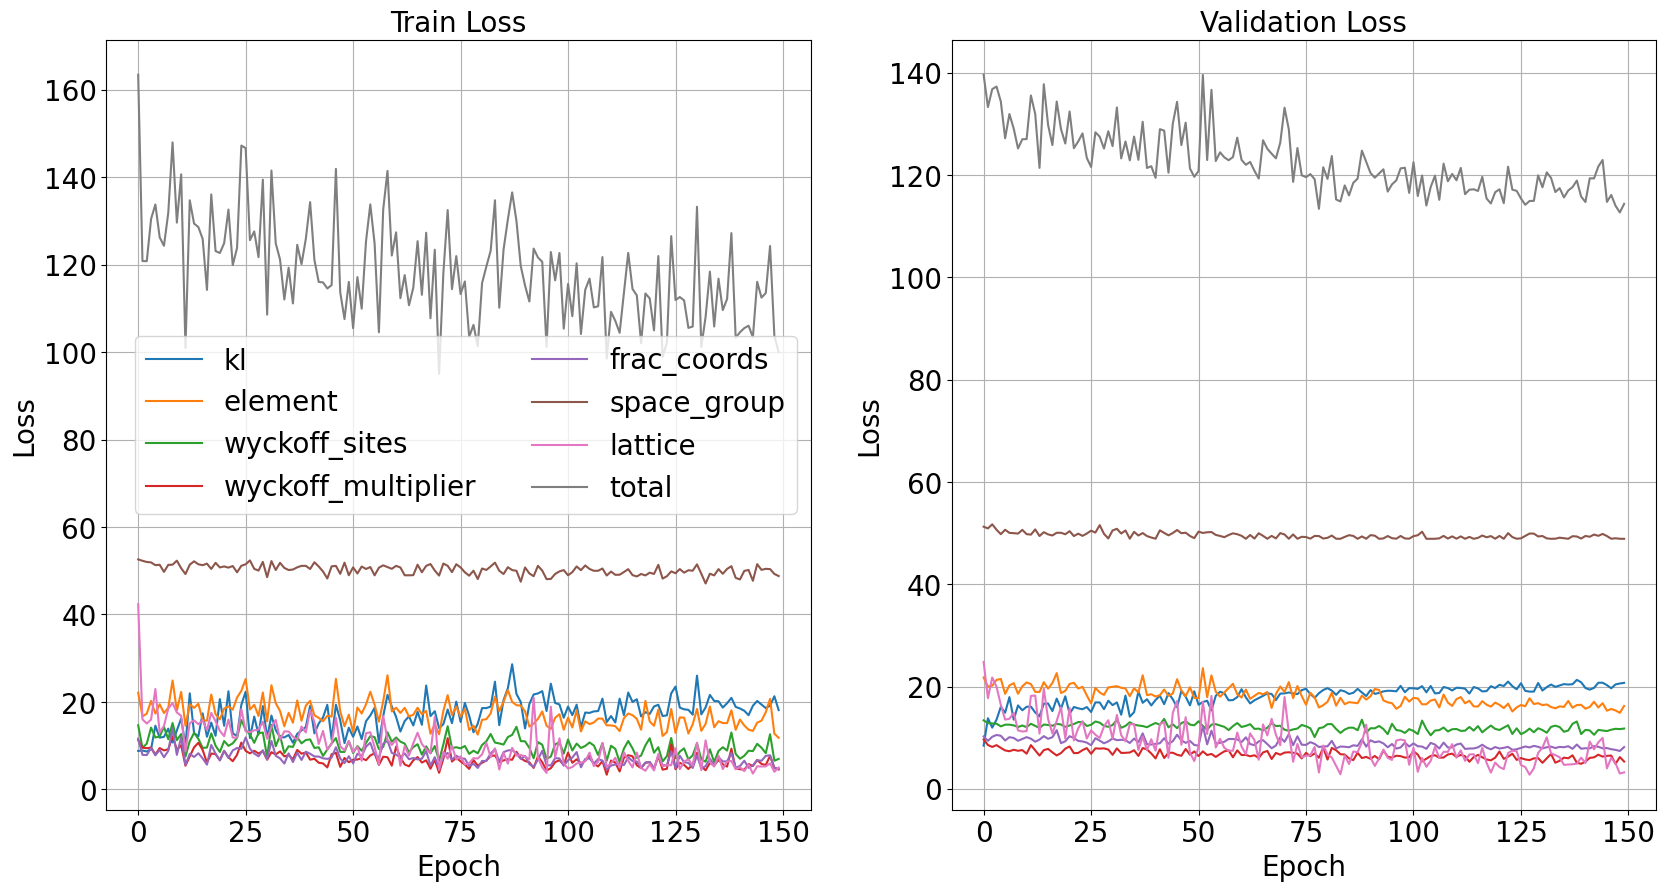

In [ ]:
## Plot all the losses as a function of the epoch
fig, ax = plt.subplots(1,2,figsize=(20,10))
font_size = 20
Nbins = 20

for key in train_loss_dict:
    ax[0].plot(train_loss_dict[key],label=key)
    val_epoch  = np.arange(0,len(val_loss_dict[key])*log_step,log_step)
    ax[1].plot(val_epoch, val_loss_dict[key],label=key)

ax[0].set_xlabel('Epoch',fontsize=font_size)
ax[0].set_ylabel('Loss',fontsize=font_size)
ax[0].set_title('Train Loss',fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0].grid(True)
ax[0].legend(fontsize=font_size,ncol=2)

ax[1].set_xlabel('Epoch',fontsize=font_size)
ax[1].set_ylabel('Loss',fontsize=font_size)
ax[1].set_title('Validation Loss',fontsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1].grid(True)
#ax[1].legend(fontsize=font_size)


In [ ]:
### Test the model on the test set and plot the results
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print('X:',x_test.shape)
print('Y:',y_test.shape)
out_test = vae(x_test, y_test)
loss_test = vae_loss_function(out_test, x_test, y_test,coeffs)
for key in loss_test:
    # print mean loss
    print(f"{key}: {loss_test[key]/len(x_test)}")


x_test_plot = x_test.cpu().detach().numpy()
y_test_plot = y_test.cpu().detach().numpy()
vae_x = out_test['reconstructed_outputs'].cpu().detach().numpy()
vae_sg = out_test['decoded_sg'].cpu().detach().numpy()
vae_lattice = out_test['decoded_lattice'].cpu().detach().numpy()
print('X:',x_test_plot.shape)
print('Y:',y_test_plot.shape)
print('VAE:',vae_x.shape)
print('VAE SG:',vae_sg.shape)
print('VAE Lattice:',vae_lattice.shape)


# Inverse transform the data
y_test_lattice = scaler_Y.inverse_transform(y_test_plot[:,:6])
y_test_sg = y_test_plot[:,6:]
vae_lattice = scaler_Y.inverse_transform(vae_lattice)


X: torch.Size([1804, 180, 24])
Y: torch.Size([1804, 236])
kl: 0.011604021303355694
element: 0.0084971459582448
wyckoff_sites: 0.004843049682676792
wyckoff_multiplier: 0.003110462101176381
frac_coords: 0.0034983078949153423
space_group: 0.027304932475090027
lattice: 0.004012610763311386
total: 0.06287053227424622
X: (1804, 180, 24)
Y: (1804, 236)
VAE: (1804, 180, 24)
VAE SG: (1804, 230)
VAE Lattice: (1804, 6)


(1804, 3) (1804, 3) (1804,)
(1804, 3) (1804, 3) (1804,)


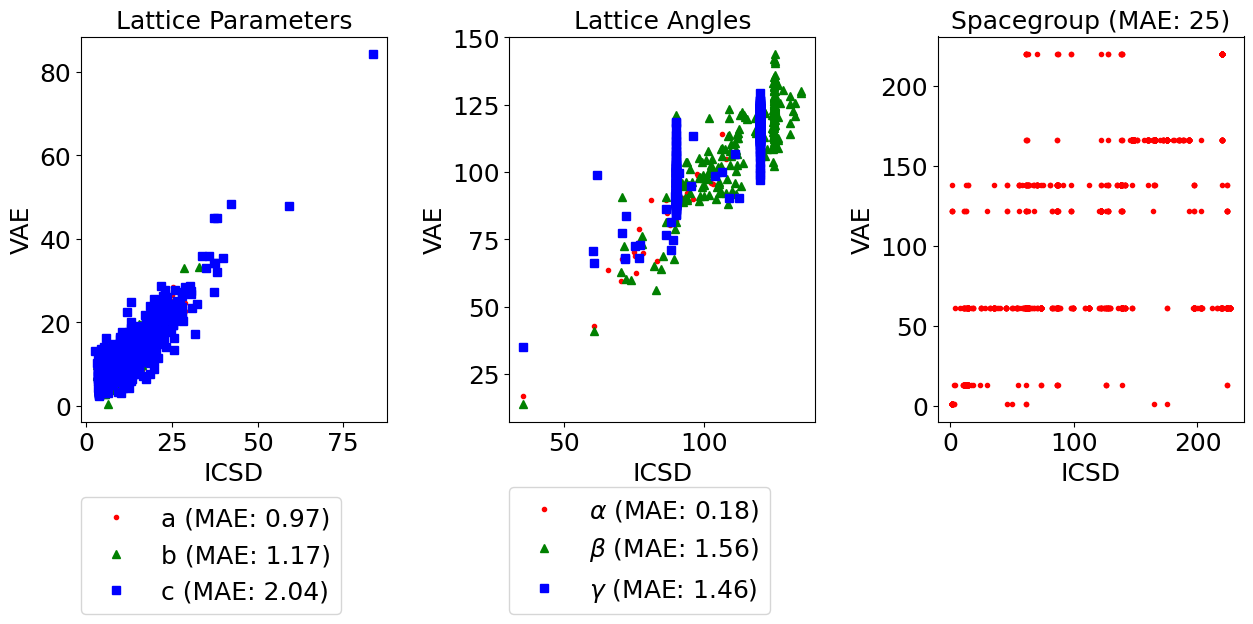

In [ ]:
abc_vae = vae_lattice[:, :3]
angles_vae = vae_lattice[:, 3:]
spacegroup_vae = np.argmax(vae_sg, axis=1)
print(abc_vae.shape, angles_vae.shape, spacegroup_vae.shape)
abc_test = y_test_lattice[:, :3]
angles_test = y_test_lattice[:, 3:6]
spacegroup_test = np.argmax(y_test_sg, axis=1)
print(abc_test.shape, angles_test.shape, spacegroup_test.shape)
# Plot the Crystal representation in three plots
fig, ax = plt.subplots(1, 3, figsize=(15, 5),gridspec_kw={'wspace':0.4})
font_size = 18
shapes = ['.','^','s']
colors = ['r','g','b']
abc_labels = ['a','b','c']
label_loc = [0,-0.5]
angle_labels = [r'$\alpha$',r'$\beta$',r'$\gamma$']
for i in range(3):
    mae = np.mean(np.abs(abc_test[:,i] - abc_vae[:,i]))
    ax[0].plot(abc_test[:,i], abc_vae[:,i], marker=shapes[i], color=colors[i], linestyle='None', label=abc_labels[i]+f' (MAE: {mae:.2f})')
    ax[0].set_xlabel('ICSD', fontsize=font_size)
    ax[0].set_ylabel('VAE', fontsize=font_size)
    ax[0].set_title('Lattice Parameters', fontsize=font_size)
    ax[0].tick_params(axis='both', which='major', labelsize=font_size)
    ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
    
    ax[0].legend(fontsize=font_size,loc=label_loc)

    mae = np.mean(np.abs(angles_test[:,i] - angles_vae[:,i]))
    ax[1].plot(angles_test[:,i], angles_vae[:,i], marker=shapes[i], color=colors[i], linestyle='None', label=angle_labels[i]+f' (MAE: {mae:.2f})')
    ax[1].set_xlabel('ICSD', fontsize=font_size)
    ax[1].set_ylabel('VAE', fontsize=font_size)
    ax[1].set_title('Lattice Angles', fontsize=font_size)
    ax[1].tick_params(axis='both', which='major', labelsize=font_size)
    ax[1].tick_params(axis='both', which='minor', labelsize=font_size)
    ax[1].legend(fontsize=font_size,loc=label_loc)

mae = np.mean(np.abs(spacegroup_test - spacegroup_vae))
ax[2].plot(spacegroup_test, spacegroup_vae, marker='.', color='r', linestyle='None')
ax[2].set_xlabel('ICSD', fontsize=font_size)
ax[2].set_ylabel('VAE', fontsize=font_size)
ax[2].set_title('Spacegroup'+f' (MAE: {mae:.0f})', fontsize=font_size)
ax[2].tick_params(axis='both', which='major', labelsize=font_size)


One hot: (1804, 101, 24)
Frac. coords: (1804, 3, 24)
Wyckoff letter: (1804, 26, 24)
Wyckoff mult: (1804, 50, 24)


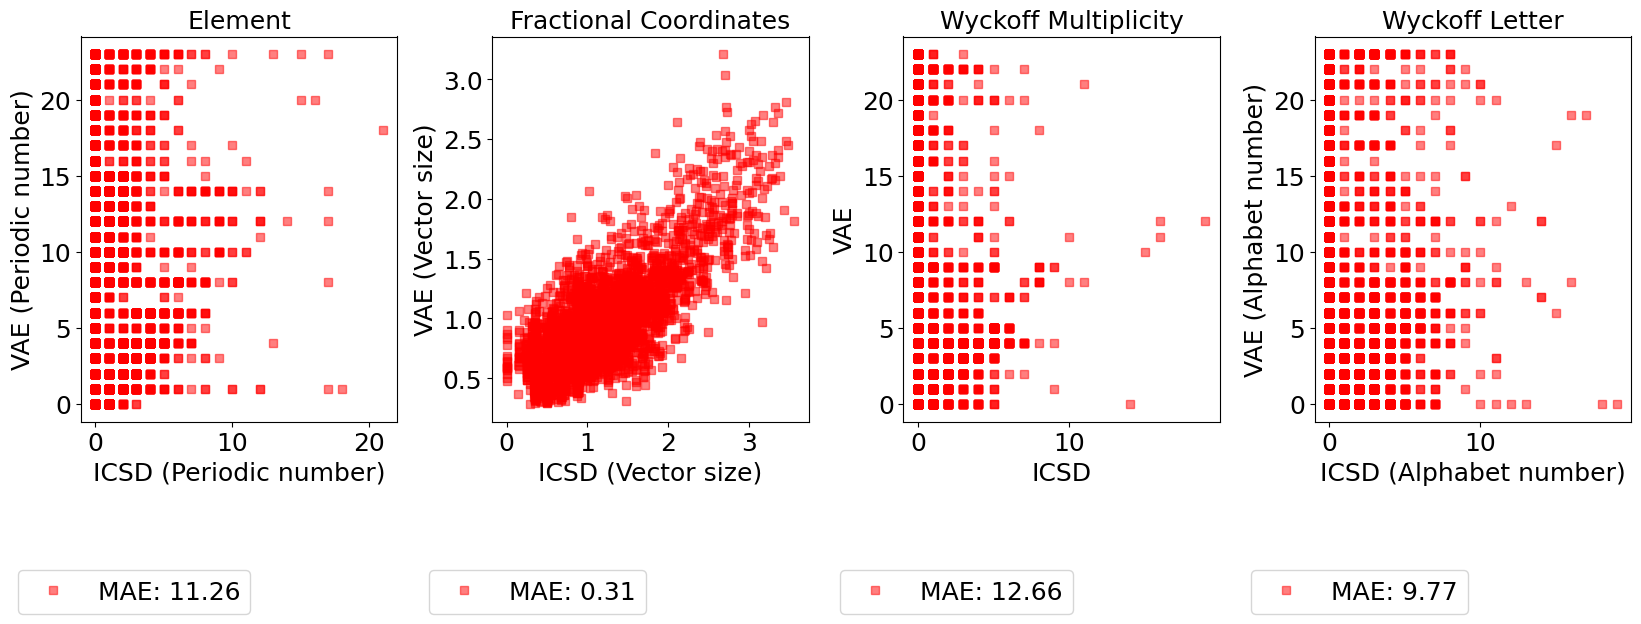

In [ ]:
onehot_test = x_test_plot[:,:101,:]
frac_coords_test = x_test_plot[:,-29:-26,:]
wyckoff_letter_test = x_test_plot[:,-26:,:]
wyckoff_mult_test = x_test_plot[:,101:-29,:]
print('One hot:',onehot_test.shape)
print('Frac. coords:',frac_coords_test.shape)
print('Wyckoff letter:',wyckoff_letter_test.shape)
print('Wyckoff mult:',wyckoff_mult_test.shape)

onehot_vae = vae_x[:,:101,:]
frac_coords_vae = vae_x[:,-29:-26,:]
wyckoff_letter_vae = vae_x[:,-26:,:]
wyckoff_mult_vae = vae_x[:,101:-29,:]

wyckoff_size = onehot_test.shape[1]
structure_size = onehot_test.shape[0]

# Plot VAE vs ICSD
fig, ax = plt.subplots(1, 4, figsize=(20, 5),gridspec_kw={'wspace':0.3})
font_size = 18
markers = ['s','^','.']
colors = ['r','g','b']
alpha = 0.5
i = 0

# Element ACC
one_hot_test_plot = onehot_test[:,:,:]
one_hot_vae_plot = onehot_vae[:,:,:]
one_hot_test_elem = np.argmax(one_hot_test_plot,axis=2)
one_hot_vae_elem = np.argmax(one_hot_vae_plot,axis=2)
# Flatten the arrays
one_hot_test_elem = one_hot_test_elem.flatten()
one_hot_vae_elem = one_hot_vae_elem.flatten()
mae = np.mean(np.abs(one_hot_test_elem - one_hot_vae_elem))
ax[0].plot(one_hot_test_elem, one_hot_vae_elem, marker=markers[i], color=colors[i], 
            linestyle='None',label=f'MAE: {mae:.2f}',alpha=alpha)
ax[0].set_xlabel('ICSD (Periodic number)', fontsize=font_size)
ax[0].set_ylabel('VAE (Periodic number)', fontsize=font_size)
ax[0].set_title('Element', fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0].legend(fontsize=font_size,loc=(-0.2,-0.5))

# Fractional Coordinates
frac_coords_test_plot = np.sqrt(np.sum(np.square(frac_coords_test[:,:,:]),axis=2))
frac_coords_vae_plot = np.sqrt(np.sum(np.square(frac_coords_vae[:,:,:]),axis=2))
frac_coords_test_plot = frac_coords_test_plot.flatten()
frac_coords_vae_plot = frac_coords_vae_plot.flatten()
mae = np.mean(np.abs(frac_coords_test_plot - frac_coords_vae_plot))
ax[1].plot(frac_coords_test_plot, frac_coords_vae_plot, marker=markers[i], color=colors[i], 
            linestyle='None',label=f'MAE: {mae:.2f}',alpha=alpha)
ax[1].set_xlabel('ICSD (Vector size)', fontsize=font_size)
ax[1].set_ylabel('VAE (Vector size)', fontsize=font_size)
ax[1].set_title('Fractional Coordinates', fontsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1].legend(fontsize=font_size,loc=(-0.2,-0.5))

# Wyckoff Multiplicity

wyckoff_mult_test_plot = np.argmax(wyckoff_mult_test[:,:,:],axis=2)
wyckoff_mult_vae_plot = np.argmax(wyckoff_mult_vae[:,:,:],axis=2)

wyckoff_mult_test_plot = wyckoff_mult_test_plot.flatten()
wyckoff_mult_vae_plot = wyckoff_mult_vae_plot.flatten()
mae = np.mean(np.abs(wyckoff_mult_test_plot - wyckoff_mult_vae_plot))
ax[2].plot(wyckoff_mult_test_plot, wyckoff_mult_vae_plot, marker=markers[i], color=colors[i],
            linestyle='None',label=f'MAE: {mae:.2f}',alpha=alpha)
ax[2].set_xlabel('ICSD', fontsize=font_size)
ax[2].set_ylabel('VAE', fontsize=font_size)
ax[2].set_title('Wyckoff Multiplicity', fontsize=font_size)
ax[2].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].tick_params(axis='both', which='minor', labelsize=font_size)
ax[2].legend(fontsize=font_size,loc=(-0.2,-0.5))

# Wyckoff Letter
wyckoff_letter_test_plot = wyckoff_letter_test[:,:,:]
wyckoff_letter_vae_plot = wyckoff_letter_vae[:,:,:]
wyckoff_letter_test_elem = np.argmax(wyckoff_letter_test_plot,axis=2)
wyckoff_letter_vae_elem = np.argmax(wyckoff_letter_vae_plot,axis=2)
# Flatten the arrays
wyckoff_letter_test_elem = wyckoff_letter_test_elem.flatten()
wyckoff_letter_vae_elem = wyckoff_letter_vae_elem.flatten()
mae = np.mean(np.abs(wyckoff_letter_test_elem - wyckoff_letter_vae_elem))
ax[3].plot(wyckoff_letter_test_elem, wyckoff_letter_vae_elem, marker=markers[i], color=colors[i], 
            linestyle='None',label=f'MAE: {mae:.2f}',alpha=alpha)
ax[3].set_xlabel('ICSD (Alphabet number)', fontsize=font_size)
ax[3].set_ylabel('VAE (Alphabet number)', fontsize=font_size)
ax[3].set_title('Wyckoff Letter', fontsize=font_size)
ax[3].tick_params(axis='both', which='major', labelsize=font_size)
ax[3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[3].legend(fontsize=font_size,loc=(-0.2,-0.5))

    